# Anomaly Detection in Timeseries: A Comprehensive Evaluation

Plots for our paper on TSAD.

In [1]:
# imports
import re
import json
import copy
import warnings
import pandas as pd
import numpy as np
import scipy as sp

from IPython.display import display, Markdown, Latex

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.lines import Line2D
from matplotlib.markers import MarkerStyle
from matplotlib.legend_handler import HandlerBase
from matplotlib.patches import Rectangle

from itertools import cycle
from pathlib import Path

from timeeval import DatasetManager as Datasets

__change fontsize__ (default: 10) __and figure size__

In [2]:
single_column_figwidth = 10
double_column_figwidth = 20
plt.rcParams.update({
    "font.size": 12,
    "font.weight": "regular",  # "bold"
    "figure.figsize": (double_column_figwidth, 8)
})

In [3]:
method_family_colormap = plt.get_cmap("Dark2")
learning_type_colormap = plt.get_cmap("tab20")

## Configuration

Define data and results folder:

In [4]:
# constants and configuration
gutentag_data_path = Path("/home/projects/akita/data") / "test-cases"
benchmark_data_path = Path("/home/projects/akita/data") / "benchmark-data" / "data-processed"
result_root_path = Path("/home/projects/akita/results").resolve()

baselines = ["normal", "Random", "increasing", "Normal Baseline", "Increasing Baseline", "Random Baseline"]
ignore_collections = ["Keogh", "SWaT", "WADI"]

# build paths
gutentag_data_path = gutentag_data_path.resolve()
benchmark_data_path = benchmark_data_path.resolve()
gutentag_result_path = result_root_path /  "2021-12-03_runtime-gutentag-2-merged"
benchmark_result_path = result_root_path / "2022-02-21_runtime-benchmark-2-merged"
print("\nSelecting:")
print(f"Data paths:\n\tGutenTAG: {gutentag_data_path}\n\tBenchmark: {benchmark_data_path}")
print(f"Result path:\n\tGutenTAG: {gutentag_result_path}\n\tBenchmark: {benchmark_result_path}")


Selecting:
Data paths:
	GutenTAG: /home/projects/akita/data/test-cases
	Benchmark: /home/projects/akita/data/benchmark-data/data-processed
Result path:
	GutenTAG: /home/projects/akita/results/2021-12-03_runtime-gutentag-2-merged
	Benchmark: /home/projects/akita/results/2022-02-21_runtime-benchmark-2-merged


Load results:

In [5]:
def prepare_df(df):
    # aggregate runtime
    df.insert(len(df.columns), "overall_time", df["execute_main_time"].fillna(0) + df["train_main_time"].fillna(0))

    # add RANGE_PR_AUC if it is not part of the results
    if "RANGE_PR_AUC" not in df.columns:
        df.insert(len(df.columns), "RANGE_PR_AUC", np.nan)

    # remove all duplicates (not necessary, but sometimes, we have some)
    df.drop_duplicates(inplace=True)
    
    # remove all baseline algorithms
    df.drop(df.index[df["algorithm"].isin(baselines)], errors="ignore", inplace=True)
    
    # remove additional dataset collections
    df.drop(df.index[df["collection"].isin(ignore_collections)], errors="ignore", inplace=True)

# load results
print(f"Reading GutenTAG results from {gutentag_result_path.resolve()}")
df_gt = pd.read_csv(gutentag_result_path / "results.csv")
print(f"Reading Benchmark results from {benchmark_result_path.resolve()}")
df_bm = pd.read_csv(benchmark_result_path / "results.csv")
    
# fix dataset name for GutenTAG datasets
df_gt["dataset"] = df_gt["dataset"].str.split(".").str[0]

prepare_df(df_gt)
prepare_df(df_bm)

# only use best hyper parameters for an algorithm-collection-dataset combination (GutenTAG)
def filter_groups(group):
    if len(group) > 1:
        group = group.sort_values(by="ROC_AUC", ascending=False)
    return group[:1]

df_grouped = df_gt.groupby(by=["algorithm", "collection", "dataset"])
df_grouped = df_grouped.apply(filter_groups)
df_gt = df_grouped.reset_index(drop=True)
df_gt = df_gt.sort_values(by=["algorithm", "dataset"])

# combine results
df = pd.concat([df_gt, df_bm], ignore_index=True)

Reading GutenTAG results from /home/projects/akita/results/2021-12-03_runtime-gutentag-2-merged
Reading Benchmark results from /home/projects/akita/results/2022-02-21_runtime-benchmark-2-merged


Extract and add error categories:

In [6]:
ok = "- OK -"
oom = "- OOM -"
timeout = "- TIMEOUT -"
error_mapping = {
    "TimeoutError": timeout,
    "status code '137'": oom,
    "MemoryError: Unable to allocate": oom,
    "ValueError: Expected 2D array, got 1D array instead": "Wrong shape error",
    "could not broadcast input array from shape": "Wrong shape error",
    "not aligned": "Wrong shape error",  # shapes (20,) and (19,500) not aligned
    "array must not contain infs or NaNs": "unexpected Inf or NaN",
    "contains NaN": "unexpected Inf or NaN",
    "cannot convert float NaN to integer": "unexpected Inf or NaN",
    "Error(s) in loading state_dict": "Model loading error",
    "EOFError": "Model loading error",
    "Restoring from checkpoint failed": "Model loading error",
    "RecursionError: maximum recursion depth exceeded in comparison": "Max recursion depth exceeded",
    "but PCA is expecting": "BROKEN Exathlon DATASETS",  # ValueError: X has 44 features, but PCA is expecting 43 features as input.
    "input.size(-1) must be equal to input_size": "BROKEN Exathlon DATASETS",
    "ValueError: The condensed distance matrix must contain only finite values.": "LinAlgError",
    "LinAlgError": "LinAlgError",
    "NameError: name 'nan' is not defined": "Not converged",
    "Could not form valid cluster separation": "Not converged",
    "contamination must be in": "Invariance/assumption not met",
    "Data must not be constant": "Invariance/assumption not met",
    "Cannot compute initial seasonals using heuristic method with less than two full seasonal cycles in the data": "Invariance/assumption not met",
    "ValueError: Anom detection needs at least 2 periods worth of data": "Invariance/assumption not met",
    "`dataset` input should have multiple elements": "Invariance/assumption not met",
    "Cannot take a larger sample than population": "Invariance/assumption not met",
    "num_samples should be a positive integer value": "Invariance/assumption not met",
    "Cannot use heuristic method to compute initial seasonal and levels with less than periods + 10 datapoints": "Invariance/assumption not met",
    "ValueError: The window size must be less than or equal to 0": "Invariance/assumption not met",
    "The window size must be less than or equal to": "Incompatible parameters",
    "window_size has to be greater": "Incompatible parameters",
    "Set a higher piecewise_median_period_weeks": "Incompatible parameters",
    "OutOfBoundsDatetime: cannot convert input with unit 'm'": "Incompatible parameters",
    "`window_size` must be at least 4": "Incompatible parameters",
    "elements of 'k' must be between": "Incompatible parameters",
    "Expected n_neighbors <= n_samples": "Incompatible parameters",
    "PAA size can't be greater than the timeseries size": "Incompatible parameters",
    "All window sizes must be greater than or equal to": "Incompatible parameters",
    "ValueError: __len__() should return >= 0": "Bug",
    "stack expects a non-empty TensorList": "Bug",
    "expected non-empty vector": "Bug",
    "Found array with 0 feature(s)": "Bug",
    "ValueError: On entry to DLASCL parameter number 4 had an illegal value": "Bug",
    "Sample larger than population or is negative": "Bug",
    "ZeroDivisionError": "Bug",
    "IndexError": "Bug",
    "status code '139'": "Bug",  # segfault
    "replacement has length zero": "Bug",
    "missing value where TRUE/FALSE needed": "Bug",
    "invalid subscript type 'list'": "Bug",
    "subscript out of bounds": "Bug",
    "invalid argument to unary operator": "Bug",
    "negative length vectors are not allowed": "Bug",
    "negative dimensions are not allowed": "Bug",
    "`std` must be positive": "Bug",
    "does not have key": "Bug",  # State '1' does not have key '1'
    "Less than 2 uniques breaks left": "Bug",
    "The encoder for value is invalid": "Bug",
    "arange: cannot compute length": "Bug",
    "n_components=3 must be between 0 and min(n_samples, n_features)": "Bug",
    "must match the size of tensor b": "Wrong shape error",
}

def get_folder(index):
    series = df.loc[index]
    if series["collection"] == "GutenTAG":
        result_path = gutentag_result_path
        dataset_name = series["dataset"] + "." + series["dataset_training_type"].lower().replace("_", "-")
    else:
        result_path = benchmark_result_path
        dataset_name = series["dataset"]
    path = (
        result_path /
        series["algorithm"] /
        series["hyper_params_id"] /
        series["collection"] /
        dataset_name /
        str(series["repetition"])
    )
    return path
    
def category_from_logfile(logfile):
    with logfile.open() as fh:
        log = fh.read()
    for error in error_mapping:
        if error in log:
            return error_mapping[error]
    #print(log)
    return "other"
    
def extract_category(series):
    status = series["status"]
    msg = series["error_message"]
    if status == "Status.OK":
        return ok
    elif status == "Status.TIMEOUT":
        return timeout
    # status is ERROR:
    elif "DockerAlgorithmFailedError" in msg:
        path = get_folder(series.name) / "execution.log"
        if path.exists():
            return category_from_logfile(path)
        return "DockerAlgorithmFailedError"
    else:
        m = re.search("^([\w]+)\(.*\)", msg)
        if m:
            error = m.group(1)
        else:
            error = msg
        return f"TimeEval:{error}"

df["error_category"] = df.apply(extract_category, axis="columns", raw=False)
df_error_category_overview = df.pivot_table(index="error_category", columns="algorithm", values="repetition", aggfunc="count")
df_error_category_overview.insert(0, "ALL (sum)", df_error_category_overview.sum(axis=1))

with pd.option_context("display.max_rows", None, "display.max_columns", None):
    display(df_error_category_overview.style.format("{:.0f}", na_rep=""))

algorithm,ALL (sum),ARIMA,Bagel,CBLOF,COF,COPOD,DBStream,DSPOT,DWT-MLEAD,DeepAnT,Donut,EncDec-AD,Extended Isolation Forest (EIF),FFT,GrammarViz,HBOS,HOT SAX,HealthESN,Hybrid Isolation Forest (HIF),Hybrid KNN,IF-LOF,ImageEmbeddingCAE,Isolation Forest (iForest),KNN,LOF,LSTM-AD,LaserDBN,Left STAMPi,MedianMethod,MultiHMM,NormA,Normalizing Flows,NumentaHTM,OceanWNN,OmniAnomaly,PCC,PCI,PST,PhaseSpace-SVM,Random Black Forest (RR),Random Forest Regressor (RR),RobustPCA,S-H-ESD (Twitter),SAND,SR-CNN,SSA,STAMP,STOMP,Series2Graph,Spectral Residual (SR),Subsequence IF,Subsequence LOF,TARZAN,TAnoGan,TSBitmap,Telemanom,Torsk,Triple ES (Holt-Winter's),VALMOD,XGBoosting (RR),k-Means
error_category,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
- OK -,41457,849,373,1100,748,1103,239,857,913,496,452,83,1123,913,886,1103,678,178,198,509,1070,463,1103,1103,1102,166,453,884,912,96,782,67,908,423,538,1103,913,877,798,460,415,521,468,647,359,908,874,898,863,913,913,895,386,176,913,518,931,696,722,466,953
- OOM -,1413,,,,355,,77,,,,3,133,,,,,10,7,,6,,,,,,312,1,,,,13,12,,,20,,,35,,75,,,,12,,,,,,,,,,48,,50,,,80,3,161
- TIMEOUT -,2792,60,87,,,,1,56,,48,4,336,,,27,,216,384,1,48,6,,,,1,75,74,16,,,92,120,4,,,,,,112,34,54,48,,48,103,5,39,15,,,,18,,341,,1,170,136,12,,
Bug,1068,,9,,,,504,,,22,10,17,,,,,9,,,6,1,6,,,,16,41,,,,9,,1,43,,,,1,,,,,,195,,,,,36,,,,32,,,,2,,99,,9
Incompatible parameters,725,,,,,,289,,,,,,,,,,,,,,,,,,,,,2,,,,,,,,,,,,,,,434,,,,,,,,,,,,,,,,,,
Invariance/assumption not met,126,,,,,,,,,,,,,,,,,,,,,,,,,,,11,,,,,,,,,,,,,,,11,,7,,,,12,,,,,4,,,,81,,,
LinAlgError,21,2,,,,,,,,,,,,,,,,,,,,,,,,,,,,,17,,,,,,,,,,,,,,,,,,2,,,,,,,,,,,,
Max recursion depth exceeded,51,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,51,,,,,,,,
Model loading error,9,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,9,,,,,,,,,,,,,,,,,,,,,,,,,,


Error summary:

In [7]:
df_error_summary = pd.DataFrame(df_error_category_overview.sum(axis=1))
df_error_summary.columns = ["count"]

df_error_summary.loc["- ERROR -", "count"] = df_error_summary[~df_error_summary.index.str.startswith("- ")].sum().item()
df_error_summary = df_error_summary.drop(df_error_summary[~df_error_summary.index.str.startswith("- ")].index)

all_count = df_error_summary.sum().item()
df_error_summary["percentage"] = df_error_summary / all_count
df_error_summary["count"] = df_error_summary["count"].astype(np.int_)
df_error_summary.style.format({"percentage": "{:06.2%}".format})

,count,percentage
error_category,,
- OK -,82914,86.31%
- OOM -,2826,02.94%
- TIMEOUT -,5584,05.81%
- ERROR -,4744,04.94%


Add algorithm metadata (families and research areas):

In [8]:
algo_meta = {
    "AD-LTI": {"name": "AD-LTI", "research_area": "Deep Learning", "method_family": "forecasting", "image_name": "", "display_name": "AD-LTI", "tex_command": "\\adlti[cite]{}"},
    "ARIMA": {"name": "ARIMA", "research_area": "Statistics (Regression & Forecasting)", "method_family": "forecasting", "image_name": "arima", "display_name": "ARIMA", "tex_command": "\\arima[cite]{}"},
    "Autoencoder (AE)": {"name": "Autoencoder (AE)", "research_area": "Deep Learning", "method_family": "reconstruction", "image_name": "autoencoder", "display_name": "AE", "tex_command": "\\autoencoder[cite]{}"},
    "Bagel": {"name": "Bagel", "research_area": "Deep Learning", "method_family": "reconstruction", "image_name": "bagel", "display_name": "Bagel", "tex_command": "\\bagel[cite]{}"},
    "CBLOF": {"name": "CBLOF", "research_area": "Ourlier Detection", "method_family": "distance", "image_name": "cblof", "display_name": "CBLOF", "tex_command": "\\cblof[cite]{}"},
    "COF": {"name": "COF", "research_area": "Ourlier Detection", "method_family": "distance", "image_name": "cof", "display_name": "COF", "tex_command": "\\cof[cite]{}"},
    "COPOD": {"name": "COPOD", "research_area": "Ourlier Detection", "method_family": "distribution", "image_name": "copod", "display_name": "COPOD", "tex_command": "\\copod[cite]{}"},
    "DenoisingAutoEncoder (DAE)": {"name": "DenoisingAutoEncoder (DAE)", "research_area": "Deep Learning", "method_family": "reconstruction", "image_name": "dae", "display_name": "DAE", "tex_command": "\\dae[cite]{}"},
    "DBStream": {"name": "DBStream", "research_area": "Ourlier Detection", "method_family": "distance", "image_name": "dbstream", "display_name": "DBStream", "tex_command": "\\dbstream[cite]{}"},
    "DeepAnT": {"name": "DeepAnT", "research_area": "Deep Learning", "method_family": "forecasting", "image_name": "deepant", "display_name": "DeepAnT", "tex_command": "\\deepant[cite]{}"},
    "DeepNAP": {"name": "DeepNAP", "research_area": "Deep Learning", "method_family": "forecasting", "image_name": "deepnap", "display_name": "DeepNAP", "tex_command": "\\deepnap[cite]{}"},
    "Donut": {"name": "Donut", "research_area": "Deep Learning", "method_family": "reconstruction", "image_name": "donut", "display_name": "Donut", "tex_command": "\\donut[cite]{}"},
    "DSPOT": {"name": "DSPOT", "research_area": "Statistics (Regression & Forecasting)", "method_family": "distribution", "image_name": "dspot", "display_name": "DSPOT", "tex_command": "\\dspot[cite]{}"},
    "DWT-MLEAD": {"name": "DWT-MLEAD", "research_area": "Signal Analysis", "method_family": "distribution", "image_name": "dwt_mlead", "display_name": "DWT-MLEAD", "tex_command": "\\dwtmlead[cite]{}"},
    "Extended Isolation Forest (EIF)": {"name": "Extended Isolation Forest (EIF)", "research_area": "Classic Machine Learning", "method_family": "trees", "image_name": "eif", "display_name": "EIF", "tex_command": "\\eif[cite]{}"},
    "EncDec-AD": {"name": "EncDec-AD", "research_area": "Deep Learning", "method_family": "reconstruction", "image_name": "encdec_ad", "display_name": "EncDec-AD", "tex_command": "\\encdecad[cite]{}"},
    "Ensemble GI": {"name": "Ensemble GI", "research_area": "Data Mining", "method_family": "encoding", "image_name": "ensemble_gi", "display_name": "Ensemble GI", "tex_command": "\\ensemblegi[cite]{}"},
    "Fast-MCD": {"name": "Fast-MCD", "research_area": "Statistics (Regression & Forecasting)", "method_family": "distribution", "image_name": "fast_mcd", "display_name": "Fast-MCD", "tex_command": "\\fastmcd[cite]{}"},
    "FFT": {"name": "FFT", "research_area": "Signal Analysis", "method_family": "reconstruction", "image_name": "fft", "display_name": "FFT", "tex_command": "\\fft[cite]{}"},
    "Random Forest Regressor (RR)": {"name": "Random Forest Regressor (RR)", "research_area": "Classic Machine Learning", "method_family": "forecasting", "image_name": "generic_rf", "display_name": "RForest", "tex_command": "\\randomforest[cite]{}"},
    "XGBoosting (RR)": {"name": "XGBoosting (RR)", "research_area": "Classic Machine Learning", "method_family": "forecasting", "image_name": "generic_xgb", "display_name": "XGBoosting", "tex_command": "\\xgboosting[cite]{}"},
    "GrammarViz": {"name": "GrammarViz", "research_area": "Data Mining", "method_family": "encoding", "image_name": "grammarviz3", "display_name": "GrammarViz", "tex_command": "\\grammarviz[cite]{}"},
    "HBOS": {"name": "HBOS", "research_area": "Classic Machine Learning", "method_family": "distance", "image_name": "hbos", "display_name": "HBOS", "tex_command": "\\hbos[cite]{}"},
    "HealthESN": {"name": "HealthESN", "research_area": "Deep Learning", "method_family": "forecasting", "image_name": "health_esn", "display_name": "HealthESN", "tex_command": "\\healthesn[cite]{}"},
    "Hybrid Isolation Forest (HIF)": {"name": "Hybrid Isolation Forest (HIF)", "research_area": "Ourlier Detection", "method_family": "trees", "image_name": "hif", "display_name": "HIF", "tex_command": "\\hif[cite]{}"},
    "HOT SAX": {"name": "HOT SAX", "research_area": "Data Mining", "method_family": "distance", "image_name": "hotsax", "display_name": "HOT SAX", "tex_command": "\\hotsax[cite]{}"},
    "Hybrid KNN": {"name": "Hybrid KNN", "research_area": "Deep Learning", "method_family": "distance", "image_name": "hybrid_knn", "display_name": "Hybrid KNN", "tex_command": "\\hybridknn[cite]{}"},
    "IF-LOF": {"name": "IF-LOF", "research_area": "Ourlier Detection", "method_family": "trees", "image_name": "if_lof", "display_name": "IF-LOF", "tex_command": "\\iflof[cite]{}"},
    "Isolation Forest (iForest)": {"name": "Isolation Forest (iForest)", "research_area": "Ourlier Detection", "method_family": "trees", "image_name": "iforest", "display_name": "iForest", "tex_command": "\\iforest[cite]{}"},
    "ImageEmbeddingCAE": {"name": "ImageEmbeddingCAE", "research_area": "Deep Learning", "method_family": "reconstruction", "image_name": "img_embedding_cae", "display_name": "IE-CAE", "tex_command": "\\iecae[cite]{}"},
    "k-Means": {"name": "k-Means", "research_area": "Classic Machine Learning", "method_family": "distance", "image_name": "kmeans", "display_name": "k-Means", "tex_command": "\\kmeans[cite]{}"},
    "KNN": {"name": "KNN", "research_area": "Classic Machine Learning", "method_family": "distance", "image_name": "knn", "display_name": "KNN", "tex_command": "\\knn[cite]{}"},
    "LaserDBN": {"name": "LaserDBN", "research_area": "Stochastic Learning", "method_family": "encoding", "image_name": "laser_dbn", "display_name": "LaserDBN", "tex_command": "\\laserdbn[cite]{}"},
    "Left STAMPi": {"name": "Left STAMPi", "research_area": "Data Mining", "method_family": "distance", "image_name": "left_stampi", "display_name": "Left STAMPi", "tex_command": "\\leftstampi[cite]{}"},
    "LOF": {"name": "LOF", "research_area": "Ourlier Detection", "method_family": "distance", "image_name": "lof", "display_name": "LOF", "tex_command": "\\lof[cite]{}"},
    "LSTM-AD": {"name": "LSTM-AD", "research_area": "Deep Learning", "method_family": "forecasting", "image_name": "lstm_ad", "display_name": "LSTM-AD", "tex_command": "\\lstmad[cite]{}"},
    "LSTM-VAE": {"name": "LSTM-VAE", "research_area": "Deep Learning", "method_family": "reconstruction", "image_name": "lstm_vae", "display_name": "LSTM-VAE", "tex_command": "\\lstmvae[cite]{}"},
    "MedianMethod": {"name": "MedianMethod", "research_area": "Statistics (Regression & Forecasting)", "method_family": "forecasting", "image_name": "median_method", "display_name": "MedianMethod", "tex_command": "\\medianmethod[cite]{}"},
    "MSCRED": {"name": "MSCRED", "research_area": "Deep Learning", "method_family": "reconstruction", "image_name": "mscred", "display_name": "MSCRED", "tex_command": "\\mscred[cite]{}"},
    "MTAD-GAT": {"name": "MTAD-GAT", "research_area": "Deep Learning", "method_family": "forecasting", "image_name": "mtad_gat", "display_name": "MTAD-GAT", "tex_command": "\\mtadgat[cite]{}"},
    "MultiHMM": {"name": "MultiHMM", "research_area": "Stochastic Learning", "method_family": "encoding", "image_name": "multi_hmm", "display_name": "MultiHMM", "tex_command": "\\multihmm[cite]{}"},
    "NormA": {"name": "NormA", "research_area": "Data Mining", "method_family": "distance", "image_name": "norma", "display_name": "NormA-SJ", "tex_command": "\\norma[cite]{}"},
    "Normalizing Flows": {"name": "Normalizing Flows", "research_area": "Deep Learning", "method_family": "distribution", "image_name": "normalizing_flows", "display_name": "Normalizing Flows", "tex_command": "\\normalizingflows[cite]{}"},
    "NoveltySVR": {"name": "NoveltySVR", "research_area": "Classic Machine Learning", "method_family": "forecasting", "image_name": "novelty_svr", "display_name": "NoveltySVR", "tex_command": "\\noveltysvr[cite]{}"},
    "NumentaHTM": {"name": "NumentaHTM", "research_area": "Deep Learning", "method_family": "forecasting", "image_name": "numenta_htm", "display_name": "NumentaHTM", "tex_command": "\\numentahtm[cite]{}"},
    "OceanWNN": {"name": "OceanWNN", "research_area": "Deep Learning", "method_family": "forecasting", "image_name": "ocean_wnn", "display_name": "OceanWNN", "tex_command": "\\oceanwnn[cite]{}"},
    "OmniAnomaly": {"name": "OmniAnomaly", "research_area": "Deep Learning", "method_family": "reconstruction", "image_name": "omnianomaly", "display_name": "OmniAnomaly", "tex_command": "\\omnianomaly[cite]{}"},
    "PCC": {"name": "PCC", "research_area": "Classic Machine Learning", "method_family": "reconstruction", "image_name": "pcc", "display_name": "PCC", "tex_command": "\\pcc[cite]{}"},
    "PCI": {"name": "PCI", "research_area": "Statistics (Regression & Forecasting)", "method_family": "reconstruction", "image_name": "pci", "display_name": "PCI", "tex_command": "\\pci[cite]{}"},
    "PhaseSpace-SVM": {"name": "PhaseSpace-SVM", "research_area": "Classic Machine Learning", "method_family": "distance", "image_name": "phasespace_svm", "display_name": "PS-SVM", "tex_command": "\\phasespacesvm[cite]{}"},
    "PST": {"name": "PST", "research_area": "Data Mining", "method_family": "trees", "image_name": "pst", "display_name": "PST", "tex_command": "\\pst[cite]{}"},
    "Random Black Forest (RR)": {"name": "Random Black Forest (RR)", "research_area": "Classic Machine Learning", "method_family": "forecasting", "image_name": "random_black_forest", "display_name": "RBForest", "tex_command": "\\randomblackforest[cite]{}"},
    "RobustPCA": {"name": "RobustPCA", "research_area": "Classic Machine Learning", "method_family": "reconstruction", "image_name": "robust_pca", "display_name": "RobustPCA", "tex_command": "\\robustpca[cite]{}"},
    "S-H-ESD (Twitter)": {"name": "S-H-ESD (Twitter)", "research_area": "Statistics (Regression & Forecasting)", "method_family": "distribution", "image_name": "s_h_esd", "display_name": "S-H-ESD", "tex_command": "\\shesd[cite]{}"},
    "SAND": {"name": "SAND", "research_area": "Data Mining", "method_family": "distance", "image_name": "sand", "display_name": "SAND", "tex_command": "\\sand[cite]{}"},
    "SARIMA": {"name": "SARIMA", "research_area": "Statistics (Regression & Forecasting)", "method_family": "forecasting", "image_name": "sarima", "display_name": "SARIMA", "tex_command": "\\sarima[cite]{}"},
    "Series2Graph": {"name": "Series2Graph", "research_area": "Data Mining", "method_family": "distance", "image_name": "series2graph", "display_name": "Series2Graph", "tex_command": "\\seriestograph[cite]{}"},
    "Spectral Residual (SR)": {"name": "Spectral Residual (SR)", "research_area": "Signal Analysis", "method_family": "reconstruction", "image_name": "sr", "display_name": "SR", "tex_command": "\\sr[cite]{}"},
    "SR-CNN": {"name": "SR-CNN", "research_area": "Deep Learning", "method_family": "reconstruction", "image_name": "sr_cnn", "display_name": "SR-CNN", "tex_command": "\\srcnn[cite]{}"},
    "SSA": {"name": "SSA", "research_area": "Data Mining", "method_family": "distance", "image_name": "ssa", "display_name": "SSA", "tex_command": "\\ssa[cite]{}"},
    "STAMP": {"name": "STAMP", "research_area": "Data Mining", "method_family": "distance", "image_name": "stamp", "display_name": "STAMP", "tex_command": "\\stamp[cite]{}"},
    "STOMP": {"name": "STOMP", "research_area": "Data Mining", "method_family": "distance", "image_name": "stomp", "display_name": "STOMP", "tex_command": "\\stomp[cite]{}"},
    "Subsequence Fast-MCD": {"name": "Subsequence Fast-MCD", "research_area": "Statistics (Regression & Forecasting)", "method_family": "distribution", "image_name": "subsequence_fast_mcd", "display_name": "Sub-Fast-MCD", "tex_command": "\\subsequencefastmcd[cite]{}"},
    "Subsequence IF": {"name": "Subsequence IF", "research_area": "Ourlier Detection", "method_family": "trees", "image_name": "subsequence_if", "display_name": "Sub-IF", "tex_command": "\\subsequenceif[cite]{}"},
    "Subsequence LOF": {"name": "Subsequence LOF", "research_area": "Ourlier Detection", "method_family": "distance", "image_name": "subsequence_lof", "display_name": "Sub-LOF", "tex_command": "\\subsequencelof[cite]{}"},
    "TAnoGAN": {"name": "TAnoGAN", "research_area": "Deep Learning", "method_family": "reconstruction", "image_name": "tanogan", "display_name": "TAnoGAN", "tex_command": "\\tanogan[cite]{}"},
    "TARZAN": {"name": "TARZAN", "research_area": "Data Mining", "method_family": "encoding", "image_name": "tarzan", "display_name": "TARZAN", "tex_command": "\\tarzan[cite]{}"},
    "Telemanom": {"name": "Telemanom", "research_area": "Deep Learning", "method_family": "forecasting", "image_name": "telemanom", "display_name": "Telemanom", "tex_command": "\\telemanom[cite]{}"},
    "Torsk": {"name": "Torsk", "research_area": "Deep Learning", "method_family": "forecasting", "image_name": "torsk", "display_name": "Torsk", "tex_command": "\\torsk[cite]{}"},
    "Triple ES (Holt-Winter's)": {"name": "Triple ES (Holt-Winter's)", "research_area": "Statistics (Regression & Forecasting)", "method_family": "forecasting", "image_name": "triple_es", "display_name": "Triple ES", "tex_command": "\\triplees[cite]{}"},
    "TSBitmap": {"name": "TSBitmap", "research_area": "Data Mining", "method_family": "encoding", "image_name": "ts_bitmap", "display_name": "TSBitmap", "tex_command": "\\tsbitmap[cite]{}"},
    "VALMOD": {"name": "VALMOD", "research_area": "Data Mining", "method_family": "distance", "image_name": "valmod", "display_name": "VALMOD", "tex_command": "\\valmod[cite]{}"},
    "Random Baseline": {"name": "Random Baseline", "research_area": "", "method_family": "baseline", "image_name": "baseline_random", "display_name": "Random Baseline", "tex_command": "Random Baseline"},
    "Normal Baseline": {"name": "Normal Baseline", "research_area": "", "method_family": "baseline", "image_name": "baseline_normal", "display_name": "Normal Baseline", "tex_command": "Normal Baseline"},
    "Increasing Baseline": {"name": "Increasing Baseline", "research_area": "", "method_family": "baseline", "image_name": "baseline_increasing", "display_name": "Increasing  Baseline", "tex_command": "Increasing Baseline"}
}

# fix some typos:
algo_meta["TAnoGan"] = algo_meta["TAnoGAN"]
algo_meta["Random"] = algo_meta["Random Baseline"]
algo_meta["random"] = algo_meta["Random Baseline"]
algo_meta["normal"] = algo_meta["Normal Baseline"]
algo_meta["increasing"] = algo_meta["Increasing Baseline"]

df["algo_family"] = df["algorithm"].apply(lambda algo: algo_meta[algo]["method_family"])
df["algo_area"] = df["algorithm"].apply(lambda algo: algo_meta[algo]["research_area"])
df["algo_display_name"] = df["algorithm"].apply(lambda algo: algo_meta[algo]["display_name"])

df[["algorithm", "algo_display_name", "algo_family", "algo_area"]]

,algorithm,algo_display_name,algo_family,algo_area
0,ARIMA,ARIMA,forecasting,Statistics (Regression & Forecasting)
1,ARIMA,ARIMA,forecasting,Statistics (Regression & Forecasting)
2,ARIMA,ARIMA,forecasting,Statistics (Regression & Forecasting)
3,ARIMA,ARIMA,forecasting,Statistics (Regression & Forecasting)
4,ARIMA,ARIMA,forecasting,Statistics (Regression & Forecasting)
...,...,...,...,...
48029,VALMOD,VALMOD,distance,Data Mining
48030,VALMOD,VALMOD,distance,Data Mining
48031,VALMOD,VALMOD,distance,Data Mining
48032,VALMOD,VALMOD,distance,Data Mining


## Remove broken datasets

Filter out datasets, which cannot be processed by at least `threshold`% of algorithms:

In [9]:
threshold = 0.5

removed_by_collection = []

index_columns = ["collection", "dataset"]
df_dataset_error_counts = df.pivot_table(index=index_columns, columns=["status"], values="repetition", aggfunc="count")
df_dataset_error_counts = df_dataset_error_counts.fillna(value=0).astype(np.int64)
df_dataset_error_counts["ALL"] = df_dataset_error_counts["Status.ERROR"] + df_dataset_error_counts["Status.OK"] + df_dataset_error_counts["Status.TIMEOUT"]
df_dataset_error_counts["Successful algorithms"] = df_dataset_error_counts["Status.OK"] / df_dataset_error_counts["ALL"]
df_dataset_error_counts = df_dataset_error_counts.sort_values(by=["Status.ERROR"], ascending=False)

df_dataset_to_remove = df_dataset_error_counts.loc[df_dataset_error_counts["Successful algorithms"] < threshold, ["Successful algorithms"]]
def find_error_categories(series):
    collection, dataset = series.name
    errors = df.loc[
        (df["collection"] == collection) &
        (df["dataset"] == dataset) &
        (df["status"] != "Status.OK"),
        "error_category"
    ].values
    unique, counts = np.unique(errors, return_counts=True)
    return ", ".join(f"{c}x {n}" for n, c in sorted(zip(unique, counts), key=lambda x: x[1], reverse=True))

df_dataset_to_remove["errors"] = df_dataset_to_remove.apply(find_error_categories, axis="columns", raw=False)
df_dataset_to_remove = df_dataset_to_remove.sort_index()

df = df[~(
    (df["collection"].isin(df_dataset_to_remove.index.get_level_values(0))) & 
    (df["dataset"].isin(df_dataset_to_remove.index.get_level_values(1)))
)]

for col, s in df_dataset_to_remove.reset_index().groupby(by="collection")[["dataset"]].count().iterrows():
    removed_by_collection.append((col, s["dataset"]))
print(f"Removed the following {len(df_dataset_to_remove)} datasets:")
display(df_dataset_to_remove.style.format({"Successful algorithms": "{:2.0%}"}))

Removed the following 71 datasets:


Filter out datasets, for which no algorithm could achieve at least an ROC_AUC score of `threshold`.

In [10]:
threshold = 0.8

df_dataset_to_remove = df.groupby(by=["collection", "dataset"])[["ROC_AUC"]].max()
df_dataset_to_remove.columns = ["Max ROC_AUC"]
df_dataset_to_remove = df_dataset_to_remove[df_dataset_to_remove["Max ROC_AUC"] < 0.8]
df_dataset_to_remove = df_dataset_to_remove.sort_index()

df = df[~(
    (df["collection"].isin(df_dataset_to_remove.index.get_level_values(0))) & 
    (df["dataset"].isin(df_dataset_to_remove.index.get_level_values(1)))
)]
for col, s in df_dataset_to_remove.reset_index().groupby(by="collection")[["dataset"]].count().iterrows():
    removed_by_collection.append((col, s["dataset"]))
print(f"Removed the following {len(df_dataset_to_remove)} datasets:")
df_dataset_to_remove.reset_index().groupby(by="collection")[["dataset"]].count()

Removed the following 78 datasets:


,dataset
collection,
Daphnet,7
Exathlon,2
GutenTAG,6
MITDB,25
Metro,1
NAB,2
NormA,1
SMD,2
SVDB,30


## Store preprocessed result dataframe to disk!

In [13]:
df.to_csv(result_root_path / "paper-plots-results.csv", index=False, header=True)

## Dataset overview (grouped by collection)

In [11]:
header = ["Origin", "Dim.", "Learn.", "# Datasets (total)", "# Datasets (used)"]
df_data = pd.read_csv(result_root_path / ".." / "data" / "benchmark-data" / "data-processed" / "datasets.csv")
df_data = df_data.drop(df_data.index[df_data["collection_name"].isin(ignore_collections)])

def combine(s):
    return "/".join(s.unique())

df_data = df_data\
    .groupby(by="collection_name")[["dataset_type", "input_type", "train_type", "dataset_name"]]\
    .agg({"dataset_type": combine, "input_type": combine, "train_type": combine, "dataset_name": "count"})
df_data.columns = header[:-1]
df_data.index.name = "Collection Name"

# also add GutenTAG dataset collection
df_tmp = pd.read_csv(result_root_path / ".." / "data" / "test-cases" / "datasets.csv")
df_tmp["dataset_name"] = df_tmp["dataset_name"].str.split(".").str[0]
df_tmp = df_tmp[["collection_name", "dataset_name", "dataset_type", "input_type", "train_type"]]\
    .groupby(by=["collection_name", "dataset_name"])\
    .agg({"dataset_type": combine, "input_type": combine, "train_type": combine})\
    .reset_index()\
    .groupby(by=["collection_name"])\
    .agg({"dataset_type": combine, "input_type": combine, "train_type": combine, "dataset_name": "count"})
df_tmp.columns = header[:-1]
df_data = pd.concat([df_data, df_tmp])

# get number of actually used datasets
df_tmp = df[["collection", "dataset"]].drop_duplicates().groupby(by=["collection"]).count()
df_tmp.columns = header[-1:]
df_data = pd.merge(df_data, df_tmp, left_index=True, right_index=True, how="left")

# add number of removed datasetes
df_tmp = pd.DataFrame(removed_by_collection, columns=["Collection Name", "# Datasets (removed)"])
df_tmp = df_tmp.groupby(by="Collection Name").sum()
df_data = pd.merge(df_data, df_tmp, left_index=True, right_index=True, how="left")

# add dataset selection (passed max contamination and min anomaly filters)
df_data.loc["CalIt2", "# Datasets (selected)"] = 1
df_data.loc["Daphnet", "# Datasets (selected)"] = 10
df_data.loc["Exathlon", "# Datasets (selected)"] = 4
df_data.loc["GHL", "# Datasets (selected)"] = 48
df_data.loc["Genesis", "# Datasets (selected)"] = 1
df_data.loc["GutenTAG", "# Datasets (selected)"] = df_data.loc["GutenTAG", "# Datasets (total)"]
df_data.loc["IOPS", "# Datasets (selected)"] = 4
df_data.loc["KDD-TSAD", "# Datasets (selected)"] = 250
#df_data.loc["Keogh", "# Datasets (selected)"] = 3
df_data.loc["MGAB", "# Datasets (selected)"] = 10
df_data.loc["MITDB", "# Datasets (selected)"] = 29
df_data.loc["Metro", "# Datasets (selected)"] = 1
df_data.loc["NAB", "# Datasets (selected)"] = 58
df_data.loc["NASA-MSL", "# Datasets (selected)"] = 16
df_data.loc["NASA-SMAP", "# Datasets (selected)"] = 35
df_data.loc["OPPORTUNITY", "# Datasets (selected)"] = 20
df_data.loc["SMD", "# Datasets (selected)"] = 25
df_data.loc["SVDB", "# Datasets (selected)"] = 46
df_data.loc["WebscopeS5", "# Datasets (selected)"] = 362
df_data.loc["NormA", "# Datasets (selected)"] = 10

df_data = df_data.sort_index().fillna(0)
df_data[["# Datasets (total)", "# Datasets (selected)", "# Datasets (used)", "# Datasets (removed)"]] = df_data[["# Datasets (total)", "# Datasets (selected)", "# Datasets (used)", "# Datasets (removed)"]].astype(np.int_)
df_data[["Origin", "Dim.", "Learn.", "# Datasets (total)", "# Datasets (selected)", "# Datasets (used)", "# Datasets (removed)"]]

,Origin,Dim.,Learn.,# Datasets (total),# Datasets (selected),# Datasets (used),# Datasets (removed)
CalIt2,real,multivariate,unsupervised,1,1,1,0
Daphnet,real,multivariate,unsupervised,35,10,3,7
Dodgers,real,univariate,unsupervised,1,0,0,0
Exathlon,real,multivariate,unsupervised/semi-supervised/supervised,39,4,2,4
GHL,synthetic,multivariate,semi-supervised,48,48,0,48
Genesis,real,multivariate,unsupervised,1,1,1,0
GutenTAG,synthetic,multivariate/univariate,unsupervised/supervised/semi-supervised,193,193,187,6
IOPS,real,univariate,supervised,29,4,4,0
KDD-TSAD,synthetic,univariate,semi-supervised,250,250,249,1
Kitsune,real,multivariate,unsupervised,9,0,0,0


## Quality overview (boxplots)

In [12]:
dominant_aggregation = "mean"
index_columns = ["algo_input_dimensionality", "algo_training_type", "algorithm"]

df_asl = df.pivot(index=index_columns, columns=["collection", "dataset"], values="ROC_AUC")
df_asl = df_asl.dropna(axis=0, how="all").dropna(axis=1, how="all")
df_asl[dominant_aggregation] = df_asl.agg(dominant_aggregation, axis=1)
df_asl = df_asl.reset_index().sort_values(by=index_columns[:-1] + [dominant_aggregation], ascending=True).set_index(index_columns)
df_asl = df_asl.drop(columns=dominant_aggregation)
#df_asl.T

/home/sebastian.schmidl/.conda/envs/timeeval/lib/python3.8/site-packages/pandas/core/generic.py:4150: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


In [13]:
df_asl_pr = df.pivot(index=index_columns, columns=["collection", "dataset"], values="PR_AUC")
df_asl_pr = df_asl_pr.dropna(axis=0, how="all").dropna(axis=1, how="all")
df_asl_pr = df_asl_pr.reindex(df_asl.index)
#df_asl_pr.T

In [14]:
df_asl_rangepr = df.pivot(index=index_columns, columns=["collection", "dataset"], values="RANGE_PR_AUC")
df_asl_rangepr = df_asl_rangepr.dropna(axis=0, how="all").dropna(axis=1, how="all")
df_asl_rangepr = df_asl_rangepr.reindex(df_asl.index)
#df_asl_pr.T

In [15]:
df_asl_gt = df[df["collection"] == "GutenTAG"].pivot(index=index_columns, columns=["collection", "dataset"], values="ROC_AUC")
df_asl_gt = df_asl_gt.dropna(axis=0, how="all").dropna(axis=1, how="all")
df_asl_gt = df_asl_gt.reindex(df_asl.index)
#df_asl_gt.T

In [16]:
relative = True

df_algorithm_error_counts = df.pivot_table(index=["algorithm"], columns=["error_category"], values="repetition", aggfunc="count")
df_algorithm_error_counts = df_algorithm_error_counts.fillna(value=0).astype(np.int64)
error_categories = [c for c in df_algorithm_error_counts.columns if not c.startswith("-")]
df_algorithm_error_counts["- ERROR -"] = df_algorithm_error_counts[error_categories].sum(axis=1)
df_algorithm_error_counts = df_algorithm_error_counts.drop(columns=error_categories)
df_algorithm_error_counts["- ALL -"] = df_algorithm_error_counts.sum(axis=1)
df_algorithm_error_counts.columns = [c.split(" ")[1] for c in df_algorithm_error_counts.columns]

def get_error_count(algo, tpe="ERROR"):
    if relative:
        return df_algorithm_error_counts.loc[algo, tpe] / df_algorithm_error_counts.loc[algo, "ALL"]
    else:
        return df_algorithm_error_counts.loc[algo, tpe]
    
overview = []
for d, l, a in df_asl.index:
    overview.append([d,l,a])
df_overview_table = pd.DataFrame(overview, columns=["dimensionality", "learning type", "algorithm"])
df_overview_table["# TIMEOUT"] = df_overview_table["algorithm"].apply(get_error_count, tpe="TIMEOUT")
df_overview_table["# OOM"] = df_overview_table["algorithm"].apply(get_error_count, tpe="OOM")
df_overview_table["# ERROR"] = df_overview_table["algorithm"].apply(get_error_count, tpe="ERROR")
df_overview_table["algorithm"] = df_overview_table["algorithm"].apply(lambda algo: algo_meta[algo]["display_name"])

percent_format = "{:03.0%}"
with pd.option_context("display.max_rows", None, "display.max_columns", None):
    display(df_overview_table.style.format({"# TIMEOUT": percent_format, "# OOM": percent_format, "# ERROR": percent_format}))

,dimensionality,learning type,algorithm,# TIMEOUT,# OOM,# ERROR
0,MULTIVARIATE,SEMI_SUPERVISED,Hybrid KNN,00%,01%,01%
1,MULTIVARIATE,SEMI_SUPERVISED,TAnoGAN,65%,00%,01%
2,MULTIVARIATE,SEMI_SUPERVISED,RobustPCA,00%,00%,00%
3,MULTIVARIATE,SEMI_SUPERVISED,LaserDBN,04%,00%,07%
4,MULTIVARIATE,SEMI_SUPERVISED,OmniAnomaly,00%,04%,02%
5,MULTIVARIATE,SEMI_SUPERVISED,DeepAnT,00%,00%,05%
6,MULTIVARIATE,SEMI_SUPERVISED,EncDec-AD,55%,26%,03%
7,MULTIVARIATE,SEMI_SUPERVISED,RBForest,06%,05%,00%
8,MULTIVARIATE,SEMI_SUPERVISED,Telemanom,00%,00%,00%
9,MULTIVARIATE,SEMI_SUPERVISED,HealthESN,66%,00%,00%


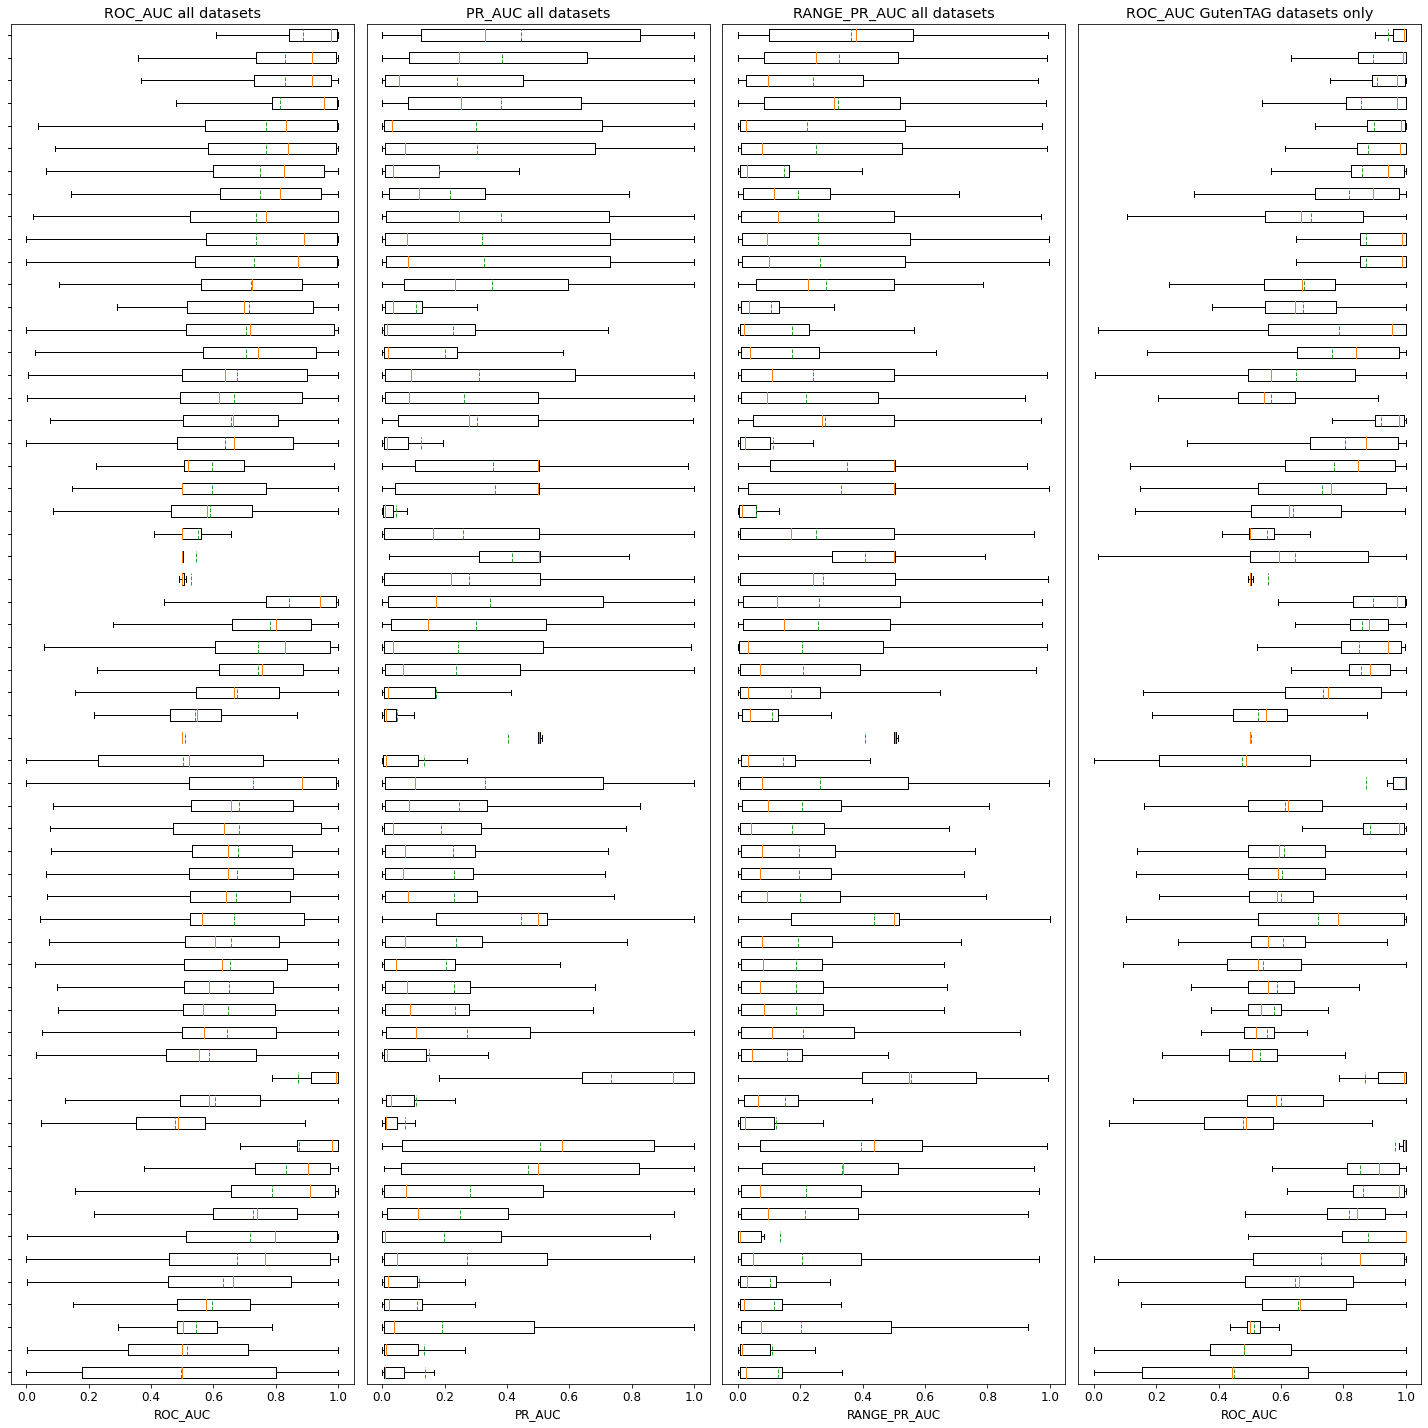

In [17]:
fliers=False
show_labels=False
title = "Overall algorithm quality"
df_boxplot = df_asl.T

labels = df_boxplot.columns
labels = [f"{c[2]}" for c in labels]

fig, axs = plt.subplots(1, 4, figsize=(20, 20), sharey=True)
ax = axs[0]
ax.boxplot([df_boxplot[c].dropna().values for c in df_boxplot.columns], labels=labels, sym=None if fliers else "", vert=False, meanline=True, showmeans=True, showfliers=fliers, manage_ticks=True)
ax.set_xlabel("ROC_AUC")
ax.set_title("ROC_AUC all datasets")
ax.set_xlim(-0.05, 1.05)
if not show_labels:
    ax.tick_params(axis="y", which="both", left=True, right=False, labelleft=False, labelright=False)

ax = axs[1]
ax.boxplot([df_asl_pr.T[c].dropna().values for c in df_boxplot.columns], labels=labels, sym=None if fliers else "", vert=False, meanline=True, showmeans=True, showfliers=fliers, manage_ticks=True)
ax.set_xlabel("PR_AUC")
ax.set_title("PR_AUC all datasets")
ax.set_xlim(-0.05, 1.05)
ax.tick_params(axis="y", which="both", left=False, right=False, labelleft=False, labelright=False)

ax = axs[2]
ax.boxplot([df_asl_rangepr.T[c].dropna().values for c in df_boxplot.columns], labels=labels, sym=None if fliers else "", vert=False, meanline=True, showmeans=True, showfliers=fliers, manage_ticks=True)
ax.set_xlabel("RANGE_PR_AUC")
ax.set_title("RANGE_PR_AUC all datasets")
ax.set_xlim(-0.05, 1.05)
ax.tick_params(axis="y", which="both", left=False, right=False, labelleft=False, labelright=False)

ax = axs[3]
ax.boxplot([df_asl_gt.T[c].dropna().values for c in df_boxplot.columns], labels=labels, sym=None if fliers else "", vert=False, meanline=True, showmeans=True, showfliers=fliers, manage_ticks=True)
ax.set_xlabel("ROC_AUC")
#ax.xaxis.set_label_position("top")
ax.set_title("ROC_AUC GutenTAG datasets only")
ax.set_xlim(-0.05, 1.05)
ax.tick_params(axis="y", which="both", left=False, right=False, labelleft=False, labelright=False)

# ax = axs[3]
# ax.axis("tight")
# ax.set_axis_off()
# table = ax.table(cellText=df_boxplot.columns, loc="center", edges="open", fontsize=200)

fig.tight_layout()
fig.show()

## Compare ranking between all datasets and GutenTAG

In [18]:
df_tmp = df.groupby(by="algorithm")[["ROC_AUC"]].mean()
df_tmp = df_tmp.sort_values(by="ROC_AUC", ascending=False)
df_tmp["Rank"] = df_tmp.rank(ascending=False)

df_tmp_gt = df[df["collection"] == "GutenTAG"].groupby(by="algo_display_name")[["ROC_AUC"]].mean()
df_tmp_gt = df_tmp_gt.sort_values(by="ROC_AUC", ascending=False)
df_tmp_gt["Rank"] = df_tmp_gt.rank(ascending=False)
df_tmp = pd.merge(df_tmp_gt, df_tmp, left_index=True, right_index=True, how="inner", suffixes=("_gt", "_all"))
df_tmp["Diff_rank"] = df_tmp["Rank_all"] - df_tmp["Rank_gt"]
df_tmp["Diff ROC_AUC"] = df_tmp["ROC_AUC_all"] - df_tmp["ROC_AUC_gt"]
df_tmp.sort_values("Diff ROC_AUC").style.format({"Diff_rank": "{:+03.0f}".format, "Diff ROC_AUC": "{:+0.2f}".format})

,ROC_AUC_gt,Rank_gt,ROC_AUC_all,Rank_all,Diff_rank,Diff ROC_AUC
Torsk,0.885825,8.000000,0.682120,28.000000,+20,-0.20
SSA,0.771233,26.000000,0.596694,46.000000,+20,-0.17
PST,0.803791,24.000000,0.636871,43.000000,+19,-0.17
EncDec-AD,0.877664,10.000000,0.716447,23.000000,+13,-0.16
k-Means,0.872913,13.000000,0.727221,21.000000,+08,-0.15
STAMP,0.874142,12.000000,0.730938,19.000000,+07,-0.14
STOMP,0.874267,11.000000,0.735858,18.000000,+07,-0.14
HOT SAX,0.731207,29.000000,0.595371,47.000000,+18,-0.14
SAND,0.898257,5.000000,0.769493,11.000000,+06,-0.13
Left STAMPi,0.880459,9.000000,0.767743,12.000000,+03,-0.11


## Reliability of our metric scores and ranking

In [19]:
def method_family_marker_map(family):
    mapping = {
        "encoding": "v",
        "distance": "o",
        "distribution": "^",
        "forecasting": "*",
        "reconstruction": "s",
        "trees": "P"
    }
    return mapping[family]

In [20]:
colormap = method_family_colormap
method_families = sorted(set([algo_meta[algo]["method_family"] for algo in algo_meta]) - {"baseline"})
annotated_algorithms = [
    "TAnoGAN",
    "EncDec-AD",
    "LSTM-AD",
    "HealthESN",
    "MultiHMM",
    "Normalizing Flows",
    "DBStream",
    "S-H-ESD",
    "DWT-MLEAD",
    "RobustPCA"
]

algo_auroc = df_asl.T.mean()
dataset_count_lut = df_algorithm_error_counts["OK"] / df_algorithm_error_counts["ALL"]
cycler = plt.cycler(marker=["o", "+", "*", "x", ".", "X"]) * plt.cycler(color=plt.get_cmap("tab20").colors)

df_tmp = algo_auroc.copy().to_frame("auroc")
df_tmp.loc[:, "reliability"] = df_tmp.index.map(lambda x: dataset_count_lut[x[2]])

In [21]:
def percentage_above(pct):
    print(f"{len(df_tmp[df_tmp.reliability > pct]) / len(df_tmp):.0%} of all algorithms reached a reliability of above {pct}.")
def percentage_below(pct):
    print(f"{len(df_tmp[df_tmp.reliability < pct]) / len(df_tmp):.0%} ({len(df_tmp[df_tmp.reliability < pct])}) of all algorithms reached a reliability of below {pct}.")

percentage_above(0.7)
percentage_above(0.99)

def algorithm_auroc_reliability(alg):
    s = df_tmp.xs(alg, level="algorithm")
    print(f"{alg} has a ROC_AUC of {s.auroc.iloc[0]:.2f} with a reliability of {s.reliability.iloc[0]:.0%}.")

algorithm_auroc_reliability("DWT-MLEAD")
algorithm_auroc_reliability("RobustPCA")
algorithm_auroc_reliability("S-H-ESD (Twitter)")
algorithm_auroc_reliability("HealthESN")

percentage_below(0.52)

87% of all algorithms reached a reliability of above 0.7.
35% of all algorithms reached a reliability of above 0.99.
DWT-MLEAD has a ROC_AUC of 0.83 with a reliability of 100%.
RobustPCA has a ROC_AUC of 0.54 with a reliability of 100%.
S-H-ESD (Twitter) has a ROC_AUC of 0.53 with a reliability of 51%.
HealthESN has a ROC_AUC of 0.83 with a reliability of 34%.
13% (8) of all algorithms reached a reliability of below 0.52.


In [22]:
from collections import defaultdict

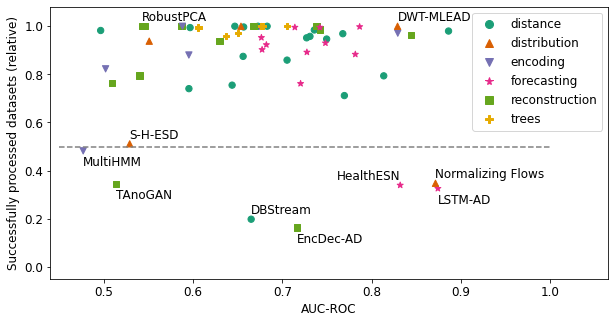

In [23]:
fig = plt.figure(figsize=(single_column_figwidth, 5))
ax = fig.gca()
ax.set_prop_cycle(cycler)

scatter_plots = defaultdict(lambda: defaultdict(list))
algo_positions = {}

for (_, _, algo), r in df_tmp.iterrows():
    algo_metadata = algo_meta[algo]
    name = algo_metadata["display_name"]
    method_family = algo_metadata["method_family"]
    x = r.auroc
    y = r.reliability
    scatter_plots[method_family]["xs"].append(x)
    scatter_plots[method_family]["ys"].append(y)
    scatter_plots[method_family]["cs"].append(colormap(method_families.index(method_family)))
    if name in annotated_algorithms:
        algo_positions[name] = (x, y)

for family, scatter in scatter_plots.items():
    xs = scatter["xs"]
    ys = scatter["ys"]
    cs = scatter["cs"]
    ax.scatter(xs, ys, color=cs, s=40, marker=method_family_marker_map(family))

ax.legend(handles=[
    Line2D([0], [0], color="w", marker=method_family_marker_map(fam), markerfacecolor=colormap(i), markeredgecolor=colormap(i), label=fam, markersize=8)
    for i, fam in enumerate(method_families)
], loc="upper right")

for a in annotated_algorithms:
    ha = "left"
    text_position = (0, 5)
    if a in ["LSTM-AD", "MultiHMM", "EncDec-AD", "TAnoGAN"]:
        text_position = (0, -15)
    if a in ["HealthESN"]:
        ha = "right"
    ax.annotate(a, algo_positions[a], textcoords="offset points", xytext=text_position, ha=ha)

# add vline to separate bad and good algos
#ax.vlines([0.75], 0, 1, colors="grey", linestyles="dashed")
ax.hlines([0.5], 0.45, 1, colors="grey", linestyles="dashed")
ax.set_xlabel("AUC-ROC")
ax.set_ylabel("Successfully processed datasets (relative)")
#ax.set_title("Reliability of the ROC_AUC values")
ax.set_xlim(0.44, 1.065)
ax.set_ylim(-0.05, 1.08)
#ax.legend(ncol=2, loc="upper left", bbox_to_anchor=(1, 1.01))
fig.savefig("plots/reliability.pdf", bbox_inches="tight")
fig.show()

## Anomaly types and data characteristics

- the heat-scatter plot ;)
- what to annotate if multiple have 100% ROC_AUC? Take into account variance, runtime, errors, name multiple?

In [24]:
colormap = method_family_colormap
method_families = sorted(set([algo_meta[algo]["method_family"] for algo in algo_meta]) - {"baseline"})

df_an = df_gt[df_gt.dataset.str.contains("-type-")]
anomaly_types = df_an.dataset.apply(lambda x: x.split("-type-")[1]).unique().tolist()

In [25]:
df_bo = df_gt.copy()
df_bo["base_oscillation"] = df_bo.dataset.apply(lambda x: x.split("-")[0])
base_oscillations = df_bo.base_oscillation.unique().tolist()

In [26]:
df_tr = df_gt.copy()
trend_data = df_gt[df_gt.dataset.str.contains("-trend-")].dataset
no_trend_data = ['sinus-noise-00%', 'sinus-noise-01%', 'sinus-noise-10%', 'sinus-noise-30%', 'sinus-noise-50%', 'sinus-same-count-1', 'sinus-same-count-2', 'sinus-same-count-5', 'sinus-same-count-10', 'sinus-diff-count-1', 'sinus-diff-count-2', 'sinus-diff-count-3', 'sinus-diff-count-4', 'sinus-diff-count-5', 'sinus-diff-count-6', 'sinus-diff-count-7', 'sinus-diff-count-8', 'sinus-diff-count-9', 'sinus-combined-diff-1', 'sinus-combined-diff-2', 'sinus-combined-diff-3', 'sinus-length-1', 'sinus-length-10', 'sinus-length-50', 'sinus-length-100', 'sinus-length-500', 'sinus-length-1000', 'sinus-type-amplitude', 'sinus-type-extremum', 'sinus-type-frequency', 'sinus-type-mean', 'sinus-type-pattern', 'sinus-type-pattern-shift', 'sinus-type-platform', 'sinus-type-trend', 'sinus-type-variance', 'sinus-channels-all-of-3', 'sinus-channels-single-of-2', 'sinus-channels-single-of-5', 'sinus-channels-single-of-10', 'sinus-channels-single-of-20', 'ecg-same-count-1', 'ecg-same-count-2', 'ecg-same-count-5', 'ecg-same-count-10', 'ecg-diff-count-1', 'ecg-diff-count-2', 'ecg-diff-count-3', 'ecg-diff-count-4', 'ecg-diff-count-5', 'ecg-diff-count-6', 'ecg-diff-count-7', 'ecg-diff-count-8', 'ecg-diff-count-9', 'ecg-combined-diff-2', 'ecg-combined-diff-3', 'ecg-length-1', 'ecg-length-10', 'ecg-length-50', 'ecg-length-100', 'ecg-length-500', 'ecg-length-1000', 'ecg-type-amplitude', 'ecg-type-extremum', 'ecg-type-frequency', 'ecg-type-mean', 'ecg-type-pattern', 'ecg-type-pattern-shift', 'ecg-type-platform', 'ecg-type-trend', 'ecg-type-variance', 'ecg-channels-all-of-3', 'ecg-channels-single-of-2', 'ecg-channels-single-of-5', 'ecg-channels-single-of-10', 'ecg-channels-single-of-20', 'cbf-same-count-1', 'cbf-same-count-2', 'cbf-same-count-5', 'cbf-same-count-10', 'cbf-diff-count-1', 'cbf-diff-count-2', 'cbf-diff-count-3', 'cbf-diff-count-4', 'cbf-diff-count-5', 'cbf-diff-count-6', 'cbf-diff-count-7', 'cbf-combined-diff-1', 'cbf-combined-diff-2', 'cbf-combined-diff-3', 'cbf-length-1', 'cbf-length-10', 'cbf-length-50', 'cbf-length-100', 'cbf-length-500', 'cbf-length-1000', 'cbf-type-amplitude', 'cbf-type-extremum', 'cbf-type-mean', 'cbf-type-pattern', 'cbf-type-platform', 'cbf-type-trend', 'cbf-type-variance', 'cbf-channels-all-of-3', 'cbf-channels-single-of-2', 'cbf-channels-single-of-5', 'cbf-channels-single-of-10', 'cbf-channels-single-of-20', 'rw-same-count-1', 'rw-same-count-2', 'rw-same-count-5', 'rw-same-count-10', 'rw-diff-count-1', 'rw-diff-count-2', 'rw-diff-count-3', 'rw-diff-count-4', 'rw-diff-count-5', 'rw-diff-count-6', 'rw-combined-diff-1', 'rw-combined-diff-2', 'rw-combined-diff-3', 'rw-length-1', 'rw-length-10', 'rw-length-50', 'rw-length-100', 'rw-length-500', 'rw-length-1000', 'rw-type-amplitude', 'rw-type-extremum', 'rw-type-mean', 'rw-type-platform', 'rw-type-trend', 'rw-type-variance', 'rw-channels-all-of-3', 'rw-channels-single-of-2', 'rw-channels-single-of-5', 'rw-channels-single-of-10', 'rw-channels-single-of-20', 'poly-same-count-1', 'poly-same-count-2', 'poly-same-count-5', 'poly-same-count-10', 'poly-diff-count-1', 'poly-diff-count-2', 'poly-diff-count-3', 'poly-diff-count-4', 'poly-diff-count-5', 'poly-combined-diff-1', 'poly-combined-diff-2', 'poly-combined-diff-3', 'poly-length-1', 'poly-length-10', 'poly-length-50', 'poly-length-100', 'poly-length-500', 'poly-length-1000', 'poly-type-extremum', 'poly-type-mean', 'poly-type-platform', 'poly-type-trend', 'poly-type-variance', 'poly-channels-all-of-3', 'poly-channels-single-of-2', 'poly-channels-single-of-5', 'poly-channels-single-of-10', 'poly-channels-single-of-20']
df_tr.loc[df_tr.dataset.isin(trend_data), "trend"] = df_tr[df_tr.dataset.isin(trend_data)].dataset.apply(lambda x: x.split("-trend-")[1])
df_tr.loc[df_tr.dataset.isin(no_trend_data), "trend"] = "no"
df_tr = df_tr[df_tr.trend.notna()]
trends = df_tr.trend.unique().tolist()

In [27]:
trends

['no', 'linear', 'quadratic', 'sinus']

In [28]:
periodic_base_oscillations = ["sinus", "ecg"]
nonperiodic_base_oscillations = ["rw", "poly", "cbf"]
periodicity_lists = [periodic_base_oscillations, nonperiodic_base_oscillations]

In [29]:
dimensions = df_gt.dataset_input_dimensionality.str.lower().unique().tolist()

In [30]:
df_an[df_an.dataset.str.contains("extremum") & (df_an.algorithm.apply(lambda a: algo_meta[a]["method_family"] == "trees"))].groupby("algorithm").mean()["ROC_AUC"]

algorithm
Extended Isolation Forest (EIF)    0.998380
Hybrid Isolation Forest (HIF)      0.999330
IF-LOF                             0.997760
Isolation Forest (iForest)         0.998500
PST                                0.805721
Subsequence IF                     0.772657
Name: ROC_AUC, dtype: float64

In [31]:
df_bo[df_bo.dataset.str.contains("rw-")].groupby("algorithm").mean()["ROC_AUC"].mean()

0.7516165504125756

In [32]:
df_bo[df_bo.dataset.str.contains("ecg-")].groupby("algorithm").mean()["ROC_AUC"].mean()

0.7057524073350329

In [33]:
df_bo[df_bo.dataset.apply(lambda x: x.split("-")[0] in periodic_base_oscillations)].groupby("algorithm").mean()["ROC_AUC"].mean()

0.7307143422346205

In [34]:
df_bo[df_bo.dataset.apply(lambda x: x.split("-")[0] in nonperiodic_base_oscillations)].groupby("algorithm").mean()["ROC_AUC"].mean()

0.6916415185380526

In [35]:
(df_bo[df_bo.dataset.apply(lambda x: x.split("-")[0] in periodic_base_oscillations)].groupby("algorithm").mean()["ROC_AUC"] > 0.9).sum()

16

In [36]:
(df_bo[df_bo.dataset.apply(lambda x: x.split("-")[0] in nonperiodic_base_oscillations)].groupby("algorithm").mean()["ROC_AUC"] > 0.9).sum()

2

In [37]:
df_gt[df_gt.dataset_input_dimensionality.str.lower() == "univariate"].groupby("algorithm").mean()["ROC_AUC"].mean()

0.7117028615498341

In [38]:
df_gt[df_gt.dataset_input_dimensionality.str.lower() == "multivariate"].groupby("algorithm").mean()["ROC_AUC"].mean()

0.6495836318457076

### Per Algorithm

In [39]:
def method_family_y(name=None, i=None):
    CHARACTER_LINE_HEIGHT = 0.6
    OFFSET = -1 + 0.3
    if name is not None:
        i = method_families.index(name)
    
    lineheight = (CHARACTER_LINE_HEIGHT / len(method_families))
    return OFFSET - i * lineheight

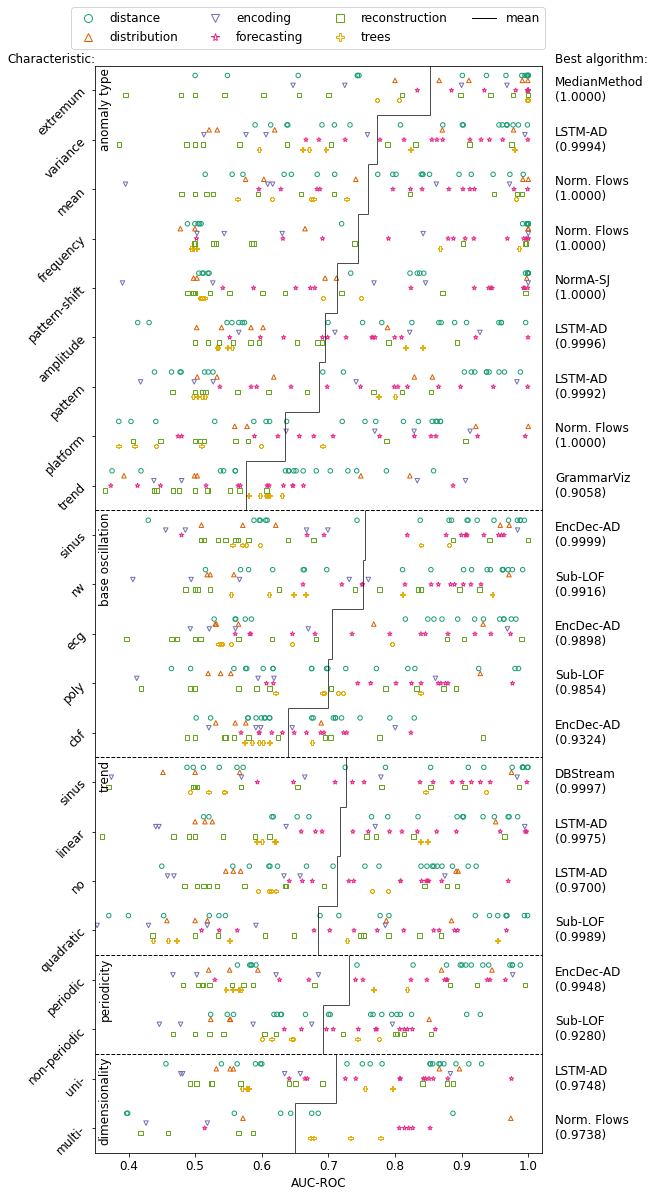

In [40]:
x_range = (0.4, 1.0)
fontsize = plt.rcParams["font.size"]
xlim_ext_l = 0.05
xlim_ext_r = 0.02

scatter_plots = defaultdict(lambda: defaultdict(list))
xs = []
ys = []
cs = []

types = []
best_per_type = []
hlines = []
means = []

fig = plt.figure(figsize=(single_column_figwidth-2, 20))
ax = fig.gca()

def get_best_algorithm(grouped: pd.DataFrame) -> str:
    auroc_mean = grouped["ROC_AUC"].mean().reset_index()
    max_auroc = auroc_mean.ROC_AUC.max()
    
    best_algorithms = auroc_mean[auroc_mean.ROC_AUC == max_auroc].algorithm.tolist()
    
    if len(best_algorithms) > 1:
        # lowest std
        auroc_std = grouped["ROC_AUC"].std().reset_index()
        auroc_std = auroc_std[(auroc_std.algorithm.isin(best_algorithms))]
        best_algorithms = auroc_std[(auroc_std.ROC_AUC == auroc_std.ROC_AUC.min())].algorithm.tolist()
        
        # fewest errors
        auroc_count = grouped["ROC_AUC"].count().reset_index()
        auroc_count = auroc_count[(auroc_count.algorithm.isin(best_algorithms))]
        best_algorithms = auroc_count[(auroc_count.ROC_AUC == auroc_count.ROC_AUC.max())].algorithm.tolist()
        
        # fastest runtime
        mean_time = grouped["overall_time"].mean().reset_index()
        mean_time = mean_time[(mean_time.algorithm.isin(best_algorithms))]
        best_algorithms = mean_time[(mean_time.overall_time == mean_time.overall_time.min())].algorithm.tolist()
    
    best_algorithm = best_algorithms[0]
    best_score = auroc_mean[auroc_mean.algorithm == best_algorithms[0]].ROC_AUC.tolist()[0]
    best_algorithm = algo_meta[best_algorithm]["display_name"]
    return f"{best_algorithm}\n({best_score:.4f})"


def fill_plot_data(name, types, df, filters, scatter_plots, best_per_type, types_list):
    local_means = []
    for i, type_ in enumerate(types):
        grouped = df[filters(type_)].groupby("algorithm")["ROC_AUC"]
        auroc = grouped.mean().reset_index()
        local_means.append(auroc.ROC_AUC.mean())
    order = np.argsort(local_means)
    
    for i, type_ in enumerate(np.array(types)[order].tolist()):
        grouped = df[filters(type_)].groupby("algorithm")
        auroc = grouped["ROC_AUC"].mean().reset_index()
        type_name = f"{type_}{name}"
        types_list.append(type_name)
        best_per_type.append(get_best_algorithm(grouped))
        means.append(auroc.ROC_AUC.mean())
        auroc = auroc[auroc.ROC_AUC >= x_range[0] - 0.05]
        for _, row in auroc.iterrows():
            method_family = algo_meta[row.algorithm]["method_family"]
            scatter_plots[method_family]["xs"].append(row.ROC_AUC)
            scatter_plots[method_family]["ys"].append(len(types_list) + method_family_y(name=method_family))
            scatter_plots[method_family]["cs"].append(colormap(method_families.index(method_family)))
    return scatter_plots, best_per_type, types_list


# dimensionality
scatter_plots, best_per_type, types = fill_plot_data("", dimensions, df_gt, lambda t: df_gt.dataset_input_dimensionality.str.lower() == t, scatter_plots, best_per_type, types)
hlines.append(len(types))

# periodicity
periodicity_types = ["periodic", "non-periodic"]
scatter_plots, best_per_type, types = fill_plot_data("", periodicity_types, df_gt, lambda t: df_gt.dataset.apply(lambda x: x.split("-")[0]).isin(periodicity_lists[periodicity_types.index(t)]), scatter_plots, best_per_type, types)
hlines.append(len(types))

# trends
scatter_plots, best_per_type, types = fill_plot_data(" trend", trends, df_tr, lambda t: df_tr.trend == t , scatter_plots, best_per_type, types)
hlines.append(len(types))

# base oscillations
scatter_plots, best_per_type, types = fill_plot_data("", base_oscillations, df_bo, lambda t: df_bo.dataset.str.startswith(t), scatter_plots, best_per_type, types)
hlines.append(len(types))

# anomaly types
scatter_plots, best_per_type, types = fill_plot_data("", anomaly_types, df_an, lambda t: df_an.dataset.str.contains(t), scatter_plots, best_per_type, types)
hlines.append(len(types))

y_lut = lambda type_: types.index(type_)
    
for family, scatter in scatter_plots.items():
    xs = scatter["xs"]
    ys = scatter["ys"]
    cs = scatter["cs"]
    ax.scatter(xs, ys, edgecolors=cs, s=20, facecolors='none', marker=method_family_marker_map(family))
ax.legend(handles=[
    Line2D([0], [0], marker=method_family_marker_map(fam), color='w', label=fam, markerfacecolor="none", markeredgecolor=colormap(i), markersize=8)
    for i, fam in enumerate(method_families)
] + [
    Line2D([0], [0], label="mean", color="black", linewidth=1)
], loc="lower right", ncol=4, bbox_to_anchor=[1+xlim_ext_r, 1.01])#[0.4, 1.01 + 1./len(types)])

annotation_x = 1.04

ax.annotate("Best algorithm:", (annotation_x, len(types)-0.45), annotation_clip=False)
for type_, best in zip(types, best_per_type):
    ax.annotate(best.replace("Normalizing", "Norm."), (annotation_x, y_lut(type_)), annotation_clip=False, fontsize=fontsize, va="center")

ax.annotate("Characteristic:", (0.35, len(types)-0.45), annotation_clip=False, ha="right")
last = 0
for hline, characteristic in zip(hlines, ["dimensionality", "periodicity", "trend", "base oscillation", "anomaly type"]):
    ax.annotate(characteristic, (x_range[0]-xlim_ext_l+0.005, hline-0.55), rotation=90, fontsize=fontsize, va="top")
    last = hline
    if characteristic != "anomaly type":
        ax.hlines(hline - 0.5, x_range[0]-xlim_ext_l, x_range[1]+xlim_ext_r, color="black", linewidth=1, linestyle="--", clip_on=False)
    
    
for mean, (i, _) in zip(means, enumerate(types)):
    ax.vlines(mean, i-0.5, i+0.5, color="black", linewidth=1, alpha=0.7)
    if len(means) > i+1 and i+1 not in hlines:
        next_mean = means[i+1]
        ax.hlines(i+0.5, min(mean, next_mean), max(mean, next_mean), color="black", linewidth=1, alpha=0.7)

plt.yticks(*zip(*list(enumerate(map(lambda x: x.replace(" trend", "").replace("variate", "-"), types)))), rotation=45)
plt.xlabel("AUC-ROC")
#plt.ylabel("Dataset characteristic")
plt.xlim(x_range[0]-xlim_ext_l, x_range[1]+xlim_ext_r)
plt.ylim(-0.5, len(types)-0.5)
plt.savefig("plots/data-characteristic-scatter-heat.pdf", bbox_inches="tight")
plt.show()

## Dimensions Influence (not for eval paper)

In [172]:
colormap = method_family_colormap

In [173]:
df_dim = df_gt.copy()
uni_datasets = df_dim[df_dim.dataset_input_dimensionality == "UNIVARIATE"].dataset.tolist()
multi_datasets = df_dim[df_dim.dataset_input_dimensionality == "MULTIVARIATE"].dataset.tolist()
df_dim.loc[df_dim.dataset.isin(uni_datasets), "ndims"] = 1
df_dim.loc[df_dim.dataset.isin(multi_datasets), "ndims"] = df_dim[df_dim.dataset.isin(multi_datasets)].dataset.apply(lambda x: int(x.split("-")[-1]))
ndimensions = df_dim.ndims.unique()

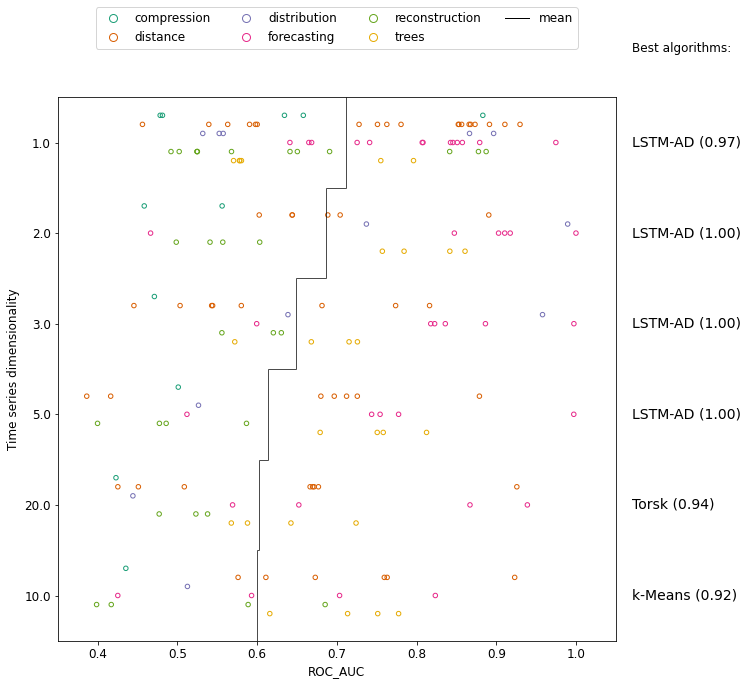

In [175]:
x_range = (0.4, 1.0)

xs = []
ys = []
cs = []

types = []
best_per_type = []
hlines = []
means = []

fig = plt.figure(figsize=(10, 10))
ax = fig.gca()

def get_best_algorithm(grouped: pd.DataFrame) -> str:
    auroc_mean = grouped["ROC_AUC"].mean().reset_index()
    max_auroc = auroc_mean.ROC_AUC.max()
    
    best_algorithms = auroc_mean[auroc_mean.ROC_AUC == max_auroc].algorithm.tolist()
    
    if len(best_algorithms) > 1:
        # lowest std
        auroc_std = grouped["ROC_AUC"].std().reset_index()
        auroc_std = auroc_std[(auroc_std.algorithm.isin(best_algorithms))]
        best_algorithms = auroc_std[(auroc_std.ROC_AUC == auroc_std.ROC_AUC.min())].algorithm.tolist()
        
        # fewest errors
        auroc_count = grouped["ROC_AUC"].count().reset_index()
        auroc_count = auroc_count[(auroc_count.algorithm.isin(best_algorithms))]
        best_algorithms = auroc_count[(auroc_count.ROC_AUC == auroc_count.ROC_AUC.max())].algorithm.tolist()
        
        # fastest runtime
        mean_time = grouped["overall_time"].mean().reset_index()
        mean_time = mean_time[(mean_time.algorithm.isin(best_algorithms))]
        best_algorithms = mean_time[(mean_time.overall_time == mean_time.overall_time.min())].algorithm.tolist()
            
    return f"{best_algorithms[0]} ({auroc_mean[auroc_mean.algorithm == best_algorithms[0]].ROC_AUC.tolist()[0]:.2f})"


def fill_plot_data(name, types, df, filters, xs, ys, cs, best_per_type, types_list):
    local_means = []
    for i, type_ in enumerate(types):
        grouped = df[filters(type_)].groupby("algorithm")["ROC_AUC"]
        auroc = grouped.mean().reset_index()
        local_means.append(auroc.ROC_AUC.mean())
    order = np.argsort(local_means)
    
    for i, type_ in enumerate(np.array(types)[order].tolist()):
        grouped = df[filters(type_)].groupby("algorithm")
        auroc = grouped["ROC_AUC"].mean().reset_index()
        type_name = f"{type_}{name}"
        types_list.append(type_name)
        best_per_type.append(get_best_algorithm(grouped))
        means.append(auroc.ROC_AUC.mean())
        auroc = auroc[auroc.ROC_AUC >= x_range[0] - 0.05]
        xs.extend(auroc.ROC_AUC)
        ys.extend([len(types_list) + method_family_y(name=algo_meta[x]["method_family"]) for _, x in auroc.algorithm.iteritems()])
        cs.extend([colormap(method_families.index(algo_meta[x]["method_family"])) for _, x in auroc.algorithm.iteritems()])
    return xs, ys, cs, best_per_type, types_list


# dimensionality
xs, ys, cs, best_per_type, types = fill_plot_data("", ndimensions, df_dim, lambda t: df_dim.ndims == t, xs, ys, cs, best_per_type, types)

y_lut = lambda type_: types.index(type_)
    
ax.scatter(xs, ys, edgecolors=cs, s=20, facecolors='none')
ax.legend(handles=[
    Line2D([0], [0], marker='o', color='w', label=fam, markerfacecolor="none", markeredgecolor=colormap(i), markersize=8)
    for i, fam in enumerate(method_families)
] + [
    Line2D([0], [0], label="mean", color="black", linewidth=1)
], loc="upper center", ncol=4, bbox_to_anchor=[0.5, 1.01 + 1./len(types)])

annotation_x = 1.07

ax.annotate("Best algorithms:", (annotation_x, len(types)), annotation_clip=False)
for type_, best in zip(types, best_per_type):
    ax.annotate(best, (annotation_x, y_lut(type_)), annotation_clip=False, fontsize=14, va="center")
    
    
for mean, (i, _) in zip(means, enumerate(types)):
    ax.vlines(mean, i-0.5, i+0.5, color="black", linewidth=1, alpha=0.7)
    if len(means) > i+1 and i+1 not in hlines:
        next_mean = means[i+1]
        ax.hlines(i+0.5, min(mean, next_mean), max(mean, next_mean), color="black", linewidth=1, alpha=0.7)

plt.yticks(*zip(*list(enumerate(types))))
plt.xlabel("ROC_AUC")
plt.ylabel("Time series dimensionality")
plt.xlim(x_range[0]-0.05, x_range[1]+0.05)
plt.ylim(-0.5, len(types)-0.5)
plt.show()

## Runtime Plot

In [33]:
def colormap(i: int, train: bool):
    if not train:
        i *= 2
    else:
        i = i * 2 + 1
    return learning_type_colormap(i)

In [34]:
gutentag_length = pd.read_csv(gutentag_data_path / "datasets.csv")[["collection_name", "dataset_name", "length"]]
gutentag_length.loc[:, "dataset_name"] = gutentag_length.dataset_name.str.split(".").apply(lambda x: x[0])
gutentag_length = gutentag_length.drop_duplicates()

benchmark_length = pd.read_csv(benchmark_data_path / "datasets.csv")[["collection_name", "dataset_name", "length"]]
df_len = pd.concat([gutentag_length, benchmark_length], ignore_index=True).set_index(["collection_name", "dataset_name"]).length

# all univariate and multivariate algorithms on as many univariate datasets as possible
df_uni = df[df.dataset_input_dimensionality == "UNIVARIATE"].copy()
df_uni.loc[:, "dataset_length"] = df_uni[["collection", "dataset"]].apply(lambda row: df_len[(row.collection, row.dataset)], axis=1)

In [35]:
# use time limit as runtime for timed-out runs and also mark it with an icon at the algorithm name
TIMEOUT = 4 * 3600
ALLOWED_STATI = [f"Status.{s.upper()}" for s in ["timeout", "ok"]]
df_uni.loc[(df_uni.status == "Status.TIMEOUT") & (df_uni.algo_training_type != "UNSUPERVISED"), "overall_time"] = TIMEOUT
df_uni.loc[(df_uni.status == "Status.TIMEOUT") & (df_uni.algo_training_type == "UNSUPERVISED"), "overall_time"] = TIMEOUT / 2
df_uni.loc[(df_uni.status == "Status.TIMEOUT") & (df_uni.algo_training_type != "UNSUPERVISED"), "train_main_time"] = TIMEOUT / 2
df_uni.loc[(df_uni.algo_training_type == "UNSUPERVISED"), "train_main_time"] = 0
df_uni.loc[df_uni.status == "Status.TIMEOUT", "execute_main_time"] = TIMEOUT / 2
df_uni = df_uni[df_uni.status.isin(ALLOWED_STATI)]

timed_out_algos = df_uni[df_uni.status == "Status.TIMEOUT"].algorithm.unique()
#df_uni.loc[:, "display_name"] = df_uni.algorithm.apply(lambda a: f"{algo_short_name_lut.get(a, a.replace(' (RR)', ''))} †" if a in timed_out_algos else f"{algo_short_name_lut.get(a, a.replace(' (RR)', ''))}  ")
mask = df_uni["algorithm"].isin(timed_out_algos)
df_uni.loc[mask, "algo_display_name"] = df_uni.loc[mask, "algo_display_name"] + " †"

# try to normalize runtime by dataset length
df_uni.loc[:, "normalized_train_time"] = df_uni.train_main_time / df_uni.dataset_length
df_uni.loc[:, "normalized_execute_time"] = df_uni.execute_main_time / df_uni.dataset_length
df_uni.loc[:, "normalized_overall_time"] = df_uni.normalized_train_time + df_uni.normalized_execute_time

In [45]:
second = 1
milli = 1000
micro = milli * 1000
nano = micro * 1000

unit_names = {
    second: "seconds",
    milli: "milliseconds",
    micro: "microseconds",
    nano: "nanoseconds"
}


def dim_mean_time(dim):
    t = df_uni.loc[df_uni.algo_input_dimensionality == dim, "normalized_overall_time"].mean()
    print(f"{dim} algorithms take on average {t:.3f} seconds per data point.")

dim_mean_time("MULTIVARIATE")
dim_mean_time("UNIVARIATE")

def tt_mean_time(training_type):
    t = df_uni.loc[df_uni.algo_training_type == training_type, "normalized_overall_time"].mean()
    print(f"{training_type} algorithms take on average {t:.3f} seconds per data point.")

print()
tt_mean_time("SUPERVISED")
tt_mean_time("SEMI_SUPERVISED")
tt_mean_time("UNSUPERVISED")

t = df_uni.loc[df_uni.algo_training_type.isin(["SUPERVISED", "SEMI_SUPERVISED"]), "normalized_overall_time"].mean()
print(f"Trained algorithms take on average {t:.3f} seconds per data point.")

def these_algos_are_faster_than(algos, faster=True):
    t = df_uni.groupby("algorithm").mean().loc[algos, "normalized_overall_time"]
    if faster:
        t = t.max() * 1000
    else:
        t = t.min() * 1000
    print(f"{', '.join(algos)} are {'faster' if faster else 'slower'} than {t:.3f} milliseconds.")

def these_algos_are_faster_than_pct_learning_type(algos, learning_type, faster=True):
    learning_type = [learning_type] if type(learning_type) == str else learning_type
    t = df_uni.groupby("algorithm").mean().loc[algos, "normalized_overall_time"]
    tmp = df_uni[df_uni.algo_training_type.isin(learning_type)].groupby("algorithm").mean()
    if faster:
        others = tmp[tmp.normalized_overall_time > t.max()]
        pct = others.shape[0] / tmp.shape[0]
    else:
        others = tmp[tmp.normalized_overall_time < t.min()]
        pct = others.shape[0] / tmp.shape[0]
    others_t = others.mean().normalized_overall_time * 1000
    print(f"{', '.join(algos)} are {'faster' if faster else 'slower'} than {pct:.0%} of {learning_type} algorithms, which take {others_t:.2f} milliseconds.")

print()
these_algos_are_faster_than(["XGBoosting (RR)", "RobustPCA", "TARZAN", "LaserDBN"])
these_algos_are_faster_than_pct_learning_type(["XGBoosting (RR)", "RobustPCA", "TARZAN", "LaserDBN"], "UNSUPERVISED")
these_algos_are_faster_than(["NormA", "Triple ES (Holt-Winter's)", "HOT SAX", "DSPOT", "ARIMA"], False)
tmp = these_algos_are_faster_than_pct_learning_type(["NormA", "Triple ES (Holt-Winter's)", "HOT SAX", "DSPOT", "ARIMA"], ["SUPERVISED", "SEMI_SUPERVISED"], False)

def algo_time(algo, unit):
    df_algo = df_uni[df_uni.algorithm == algo][["normalized_overall_time", "ROC_AUC"]].mean()
    t = df_algo.normalized_overall_time * unit
    auroc = df_algo.ROC_AUC
    print(f"{algo} takes {t:.2f} {unit_names[unit]} with a ROC_AUC score of {auroc}.")

print()
algo_time("TSBitmap", micro)
algo_time("Normalizing Flows", second)
algo_time("DWT-MLEAD", milli)
algo_time("STOMP", milli)

MULTIVARIATE algorithms take on average 0.127 seconds per data point.
UNIVARIATE algorithms take on average 0.044 seconds per data point.

SUPERVISED algorithms take on average 0.404 seconds per data point.
SEMI_SUPERVISED algorithms take on average 0.248 seconds per data point.
UNSUPERVISED algorithms take on average 0.029 seconds per data point.
Trained algorithms take on average 0.255 seconds per data point.

XGBoosting (RR), RobustPCA, TARZAN, LaserDBN are faster than 2.439 milliseconds.
XGBoosting (RR), RobustPCA, TARZAN, LaserDBN are faster than 68% of ['UNSUPERVISED'] algorithms, which take 40.69 milliseconds.
NormA, Triple ES (Holt-Winter's), HOT SAX, DSPOT, ARIMA are slower than 125.199 milliseconds.
NormA, Triple ES (Holt-Winter's), HOT SAX, DSPOT, ARIMA are slower than 55% of ['SUPERVISED', 'SEMI_SUPERVISED'] algorithms, which take 37.73 milliseconds.

TSBitmap takes 927.01 microseconds with a ROC_AUC score of 0.5881031348953089.
Normalizing Flows takes 0.95 seconds with a R

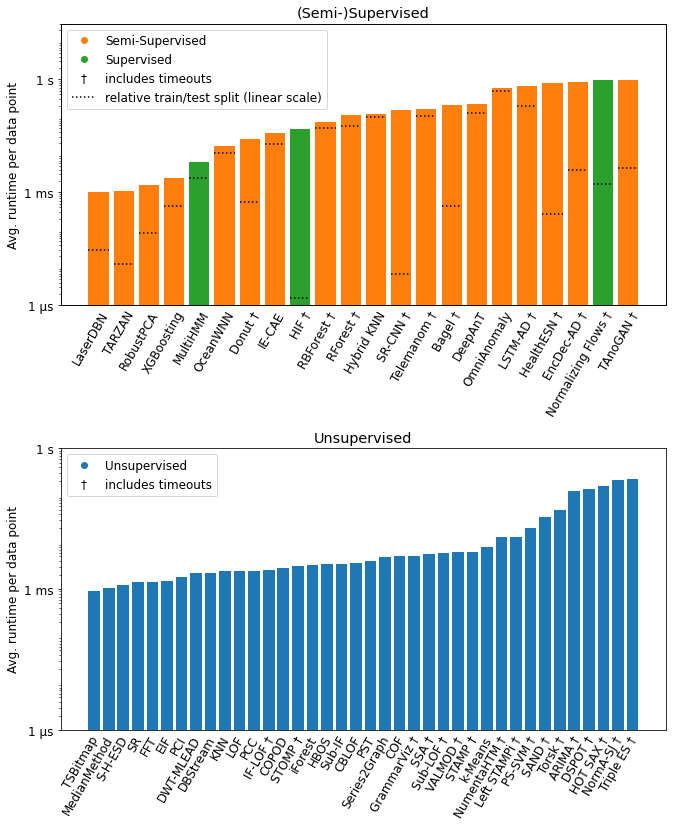

In [46]:
xlim = (0, TIMEOUT + 1000)
ylim = (-1, len(df_uni.algorithm.unique()))
#df_uni.loc[:, "test_plot_time"] = df_uni.normalized_execute_time + df_uni.normalized_train_time
plotted_values = ["normalized_overall_time", "normalized_train_time"]
sort_by = "normalized_overall_time"
groupby = "algo_display_name"

yticks = [1e-9, 1e-6, 1e-3, 1e0][1:]
ylabels = ["1 ns", "1 μs", "1 ms", "1 s"][1:]
y_range = 1e6*30
def get_absolute_from_ns(ns):
    return np.log10(ns * 1e6) / np.log10(y_range)

training_types = df_uni.algo_training_type.unique().tolist()
sorted_algos_unsupervised = df_uni[df_uni.algo_training_type == "UNSUPERVISED"].groupby(groupby).mean()[sort_by].reset_index().sort_values(by=sort_by)[groupby]
sorted_algos_supervised = df_uni[df_uni.algo_training_type != "UNSUPERVISED"].groupby(groupby).mean()[sort_by].reset_index().sort_values(by=sort_by)[groupby]
algo_groups = [("(Semi-)Supervised", sorted_algos_supervised), ("Unsupervised", sorted_algos_unsupervised)]

# create figure
fig, axs = plt.subplots(len(algo_groups), 1, figsize=(single_column_figwidth, 12))

for a, (title, algos) in enumerate(algo_groups):
    ax = axs[a]
    df_tmp = df_uni[df_uni["algo_display_name"].isin(algos)]
    for i, plot_val in enumerate(plotted_values):
        if i == 0:
            auroc_train = df_tmp.groupby(groupby).mean()[plot_val].loc[algos].reset_index()
            cs = [colormap(training_types.index(df_tmp[df_tmp[groupby] == j].algo_training_type.tolist()[0]), False) for j in auroc_train[groupby]]
            ax.bar(auroc_train[groupby], auroc_train[plot_val], align="center", color=cs)
            continue
        if a == 0:
            axh = ax.twinx()
            axh.set_ylim(0, 1)
            axh.tick_params(axis="y", which='both', length=0)
            axh.set_yticks([])
            auroc_train = df_tmp.groupby(groupby).mean().loc[algos].reset_index()
            x_range = range(len(algos))
            overall = auroc_train["normalized_overall_time"]
            rel_to_overall = auroc_train[plot_val] / overall
            hlines_y = overall.apply(lambda x: get_absolute_from_ns(x)) * rel_to_overall
            axh.hlines(hlines_y, [x-0.4 for x in x_range], [x+0.4 for x in x_range], color="black", linestyle="dotted")
        
    ax.set_yscale("log")
    ax.set_ylim(yticks[0], yticks[-1])
    ax.set_yticks(yticks)
    ax.set_yticklabels(ylabels)
    ax.set_xticks([i + 0.5 for i in range(len(algos))])
    ax.set_xticklabels(algos, rotation=60, ha="right")
    ax.set_title(title)
    ax.tick_params(axis='x', which='both', length=0)
    ax.set_ylabel("Avg. runtime per data point")


dagger = ax.text(x=0.001, y=0.001, s='†', color='black',size=0)

class TextHandler(HandlerBase):
    def create_artists(self, legend, orig_handle,xdescent, ydescent,
                        width, height, fontsize,trans):
        h = copy.copy(orig_handle)
        h.set_position((width/2.,height/2.))
        h.set_transform(trans)
        h.set_ha("center");h.set_va("center")
        fp = orig_handle.get_font_properties().copy()
        fp.set_size(fontsize)
        # uncomment the following line, 
        # if legend symbol should have the same size as in the plot
        h.set_font_properties(fp)
        return [h]

handlermap = {type(dagger) : TextHandler()}

fig.add_subplot(111, frameon=False)
upper_legend = [
    Line2D([0], [0], color="w", marker="o", markerfacecolor=colormap(i, False), markeredgecolor=colormap(i, False))
    for i, _ in enumerate(training_types[1:], 1)
] + [dagger] + [
    Line2D([0], [0], color="black", linestyle="dotted")
]
legend_labels = ["Semi-Supervised", "Supervised"] + ["includes timeouts", "relative train/test split (linear scale)"]
axs[0].legend(
    handles=upper_legend,
    labels=legend_labels,
    ncol=1,
    handler_map=handlermap,
    loc="upper left",
)
axs[0].set_ylim(yticks[0], yticks[-1]*30)

lower_legend = [
    Line2D([0], [0], color="w", marker="o", markerfacecolor=colormap(i, False), markeredgecolor=colormap(i, False))
    for i, _ in enumerate(training_types[:1])
] + [dagger]
legend_labels = ["Unsupervised"] + ["includes timeouts"]
axs[1].legend(
    handles=lower_legend,
    labels=legend_labels,
    ncol=1,
    handler_map=handlermap,
    loc="upper left",
)

#plt.xlim(10e-10, 10e1)
#plt.ylim(*ylim)

plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
"""plt.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False,
    left=False,
    right=False,
    labelleft=False)"""
plt.subplots_adjust(hspace=0.5)
plt.savefig("plots/runtime-overall.pdf", bbox_inches="tight")
plt.tight_layout()
plt.show()

## Example results

In [181]:
def load_scores_df(algorithm_name, dataset_id, repetition=1):
    series = df.loc[(df["algorithm"] == algorithm_name) & (df["collection"] == dataset_id[0]) & (df["dataset"] == dataset_id[1])]
    params_id = series["hyper_params_id"].item()
    dataset_learning_type = series["dataset_training_type"].item().lower().replace("_", "-")
    
    path = (
        (gutentag_result_path if dataset_id[0] == "GutenTAG" else benchmark_result_path) /
        algorithm_name /
        params_id /
        dataset_id[0] /
        (f"{dataset_id[1]}.{dataset_learning_type}" if dataset_id[0] == "GutenTAG" else dataset_id[1]) /
        str(repetition) /
        "anomaly_scores.ts"
    )
    return pd.read_csv(path, header=None)

In [182]:
collection_name = "GutenTAG"
dataset_name = "sinus-diff-count-5"
dataset_id = (collection_name, f"{dataset_name}.unsupervised")
algorithms = [
    "GrammarViz",
    "Subsequence LOF",
    "DWT-MLEAD",
    "DeepAnT",
    "Donut",
    "Subsequence IF"
]
anomaly_highlight_color = "red"
anomaly_highlight_color_alpha = 0.4
colors = cycle(["orange", "purple", "brown"])

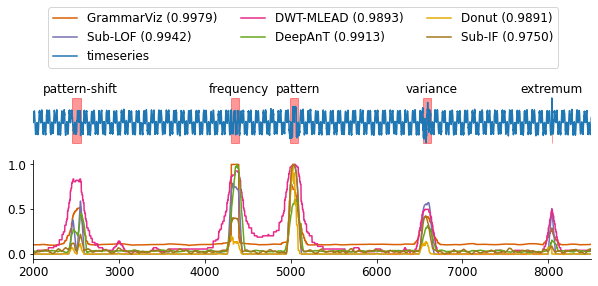

In [186]:
# load dataset details and AUROC scores
if collection_name == "GutenTAG":
    dmgr = Datasets(gutentag_data_path, create_if_missing=False)
else:
    dmgr = Datasets(benchmark_data_path, create_if_missing=False)
df_dataset = dmgr.get_dataset_df(dataset_id)
data = df_dataset.iloc[:, 1]

# find anomalies
s_anomaly_labels = df_dataset["is_anomaly"].diff()
anomalies = []
for begin, end in zip(s_anomaly_labels[s_anomaly_labels == 1].index, s_anomaly_labels[s_anomaly_labels == -1].index):
    anomalies.append((begin, end))

auroc = {}
df_scores = pd.DataFrame(index=df_dataset.index)
skip_algos = []
algos = []
for algo in algorithms:
    algos.append(algo)
    # get algorithm metric results
    try:
        auroc[algo] = df.loc[(df["algorithm"] == algo) & (df["dataset"] == dataset_name), "ROC_AUC"].item()
    except ValueError:
        warnings.warn(f"No ROC_AUC score found! Probably {algo} was not executed on {dataset_name}.")
        auroc[algo] = -1
        skip_algos.append(algo)
        continue

    # load scores
    try:
        df_scores[algo] = load_scores_df(algo, (collection_name, dataset_name)).iloc[:, 0]
    except (ValueError, FileNotFoundError):
        warnings.warn(f"No anomaly scores found! Probably {algo} was not executed on {dataset_name}.")
        df_scores[algo] = np.nan
        skip_algos.append(algo)
selected_algorithms = [a for a in algos if a not in skip_algos]

# Create plot
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(single_column_figwidth, 3), gridspec_kw={"height_ratios": [1, 2]})
axs[0].plot(df_dataset.index, data, label="timeseries")
# axs[1].plot(df_dataset.index, df_dataset["is_anomaly"], label="label")

# mark anomalies:
anomaly_kinds = ["pattern-shift", "frequency", "pattern", "variance", "extremum"]
minimum = data.min()
maximum = data.max()
for (begin, end), kind in zip(anomalies, anomaly_kinds):
    width = end-begin
    if width < 2:
        width += 2
        begin -= 1
    axs[0].add_patch(Rectangle(
        (begin, minimum),
        width,
        maximum-minimum,
        color=anomaly_highlight_color, alpha=anomaly_highlight_color_alpha
    ))
    pos = (begin+end-begin, maximum)
    axs[0].annotate(kind, pos, ha="center", xytext=(0, 5), textcoords="offset points")

method_families = sorted(set([algo_meta[algo]["method_family"] for algo in algo_meta]))
for algo in selected_algorithms:
    algo_metadata = algo_meta[algo]
    name = algo_metadata["display_name"]
    color = method_family_colormap(method_families.index(algo_metadata["method_family"]))
    axs[1].plot(df_scores.index, df_scores[algo], color=color, label=f"{name} ({auroc[algo]:.4f})")

# display styling
axs[0].axis("off")
axs[0].set_xlim(2000, 8500)

spines = axs[1].spines
spines["top"].set_visible(False)
spines["right"].set_visible(False)

# create legend
lines, labels = axs[1].get_legend_handles_labels()
# lines.append(Rectangle((0,0), 1, 1, color="yellow", alpha=0.75))
# labels.append("Anomalies")
li2, la2 = axs[0].get_legend_handles_labels()
lines = lines[:2] + li2 + lines[2:]
labels = labels[:2] + la2 + labels[2:]
legend = fig.legend(
    lines, labels,
    loc="center",
    ncol=3,
    bbox_to_anchor=(0.5, 1.15),
    borderaxespad=0.,
)

plt.savefig("plots/example-scores.pdf", bbox_inches="tight", bbox_extra_artists=[legend])
fig.show()